In [24]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file
# This block of code separates v_tilde_grid of hiring from v_hat_grid of outsourcing

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize, int32, float64
from IPython.core.debugger import set_trace
from interpolation import interp

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        self.y_min, self.y_max = y_min, y_max
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        self.o_min, self.o_max = o_min, o_max
        
        self.phi = phi
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_tilde_grid, v_o_grid, n_tilde_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_tilde_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v_tilde = max(np.sum(v_tilde_grid[:y_i] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_tilde_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate theta and pi 
        v_sum = v_tilde + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_tilde_grid * rm) / v_tilde, 1)
        f_grid = v_tilde_grid / v_tilde
        f_grid[y_hat:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_tilde_grid)
        n_temp[y_i:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_tilde_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
                n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        # Interpolate y_hat over a much finer grid
        y_fine = np.linspace(min(y_grid), max(y_grid), y_grid_size * 10)
        J_hire_fine = interp(y_grid, J_hire, y_fine)
        J_out_fine = interp(y_grid, J_out, y_fine)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out_fine - J_hire_fine))
        y_zero = np.argmin(np.abs(J_out_fine))
        y_hat_new = y_fine[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_tilde_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_tilde_grid_new = (1 - delta) * (1 - D_grid) * n_tilde_grid + q(theta) * G_grid * v_tilde_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return (v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        QD = np.sum(n_hat_grid[y_hat:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED
    
    return iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid,
    n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
    while i < max_iter and err > tol:
        (v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new) = iterate(
            v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )
        err_v_t = np.max(np.abs(v_tilde_grid_new - v_tilde_grid))
        err_v_h = np.max(np.abs(v_hat_grid_new - v_hat_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n_t = np.max(np.abs(n_tilde_grid_new - n_tilde_grid))
        err_n_h = np.max(np.abs(n_hat_grid_new - n_hat_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v_t, err_v_h, err_v_o, err_n_t, err_n_h, err_n_o)
        i += 1
        
        v_tilde_grid = slow * v_tilde_grid_new + (1 - slow) * v_tilde_grid
        v_hat_grid = slow * v_hat_grid_new + (1 - slow) * v_hat_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_tilde_grid = slow * n_tilde_grid_new + (1 - slow) * n_tilde_grid
        n_hat_grid = slow * n_hat_grid_new + (1 - slow) * n_hat_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
        y_hat = slow * y_hat_new + (1 - slow) * y_hat 
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1/5 if greater/less (depend on size)        
#         y_pos = 1 * (y_hat_new > y_hat) + 4 * (y_hat_new - y_hat > 50)
#         y_neg = 1 * (y_hat_new < y_hat) + 4 * (y_hat_new - y_hat < -50)
#         y_hat = y_hat + y_pos - y_neg
        
#         R_pos = 1 * (R_grid_new > R_grid) + 4 * (R_grid_new - R_grid > 50)
#         R_neg = 1 * (R_grid_new < R_grid) + 4 * (R_grid_new - R_grid < -50)
#         R_grid = R_grid + R_pos - R_neg
        
#         R_o_pos = 1 * (R_o_grid_new > R_o_grid) + 4 * (R_o_grid_new - R_o_grid > 50)
#         R_o_neg = 1 * (R_o_grid_new < R_o_grid) + 4 * (R_o_grid_new - R_o_grid < -50)
#         R_o_grid = R_o_grid + R_o_pos - R_o_neg
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
#         y_hat = y_hat + 1 * (y_hat_new > y_hat) - 1 * (y_hat_new < y_hat)
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)
        

    if verbose:
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        (theta_new, G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_tilde_grid_new, v_o_grid_new, n_tilde_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"y_hat is {y_hat:.4f}, y_hat_new is {y_hat_new:.4f}")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old J_hire")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new J_hire")
        ax.legend()
        plt.show()       
        
    return (
        v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
        n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS_ED, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_tilde_grid = np.ones(y_grid_size) / y_grid_size
        n_tilde_grid = np.ones(y_grid_size) / y_grid_size
        v_hat_grid = np.ones(y_grid_size) / y_grid_size
        n_hat_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.argmin(np.abs(p - y_grid))
        y_hat = p
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        
        (v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            ooj, p, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        test.append(ED)
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2
        
#         # Initial guesses (reset initially)
#         if j <= 5:
        v_tilde_grid = np.ones(y_grid_size) / y_grid_size
        n_tilde_grid = np.ones(y_grid_size) / y_grid_size
        v_hat_grid = np.ones(y_grid_size) / y_grid_size
        n_hat_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.argmin(np.abs(p - y_grid))
        y_hat = p
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
              
        (v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            ooj, p, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ED > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
                  n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    y_i = find_y_i(y_hat)
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_tilde_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_tilde_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_tilde_grid, alpha=0.75, label=r"Hiring Vacancies $\tilde{v}$")
    ax.plot(y_grid, v_hat_grid, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_tilde_grid, alpha=0.75, label=r"Hiring Positions $\tilde{n}$")
    ax.plot(y_grid, n_hat_grid, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_tilde_grid
    quits = (1 - delta) * D_grid * n_tilde_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    mc_tilde = c(v_tilde_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid) 
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc_tilde, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc_tilde
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_tilde_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_tilde_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v_tilde = np.sum(v_tilde_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_tilde_grid * rm) / v_tilde, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\breve{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\breve{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\breve{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=None):
    
    _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_tilde_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_tilde_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_tilde_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_tilde_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_tilde_grid[:y_i] * D_grid[:y_i] * rm) / np.sum(n_tilde_grid[:y_i] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss_tilde = v_tilde_grid * q(theta) * G_grid / (delta + D_grid - delta * D_grid)
    err_tilde = max(np.abs(n_ss_tilde - n_tilde_grid))
    err_tilde_at = np.argmax(np.abs(n_ss_tilde - n_tilde_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max(np.abs(n_ss_hat - n_hat_grid))
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + D_o_grid - delta_o * D_o_grid)
    err_o = max(np.abs(n_o_ss - n_o_grid))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms largest error = {err_tilde:.6f} at position {err_tilde_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: \n
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. \n
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} \n
        Workers match with probability {ell(theta) * 100:.2f}. \n
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} \n
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f} \n
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers, \n
        {zeta * 100:.0f} percent of postions outsourced \n
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f} \n
        and {per_from_u:0f} of new jobs are from unemployment \n
        Checking if vacancies + LoM imply right positions:\n
        Hiring firms largest error = {err_tilde:.6f} at position {err_tilde_at} \n
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
def save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, gamma, gamma_o = ooj.phi, ooj.gamma, ooj.gamma_o
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation\n:
    B = {B} \n
    r = {r} \n
    delta = {delta} \n
    delta_o = {delta_o} \n
    delta_hat = {delta_hat} \n 
    eta = {eta} \n
    eta_o = {eta_o} \n
    phi = {phi} \n 
    xi = {xi} \n
    y_min = {y_min} \n 
    y_max = {y_max} \n
    y_grid_size = {y_grid_size} \n
    o_min = {o_min} \n 
    o_max = {o_max} \n
    o_grid_size = {o_grid_size} \n
    b = {b} \n 
    gamma = {gamma} \n 
    gamma_o = {gamma_o} \n 
    """ + k_names)
    
    f.write(f"""
    The code runs using these parameters: \n
    p_low = {p_low} \n
    p_high = {p_high} \n
    tol = {tol} \n
    max_iter = {max_iter} \n
    tol_i = {tol_i} \n
    max_iter_i = {max_iter_i} \n 
    slow_i = {slow_i}    
    """)    

The indifferent firm is y_hat = 11.62$. Price of outsourcing is 11.24.
Unemployment is 1.66. According to LoM, should be 1.68
Workers match with probability 26.80. Firms/Outsourcers match with probability 14.92
Total vacancies searching for workers are 0.2064. Theta is 1.7960
17 percent of vacancies searching for workers are from outsourcers, 16 percent of postions outsourced
The ue rate is 0.2680, the ee rate is 0.0120,  and 27.366958 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms largest error = 0.007399 at position 756 
 Outsourcing firms largest error = 0.008047 at position 960
 Outsourcer largest error = 0.013421 at position 302


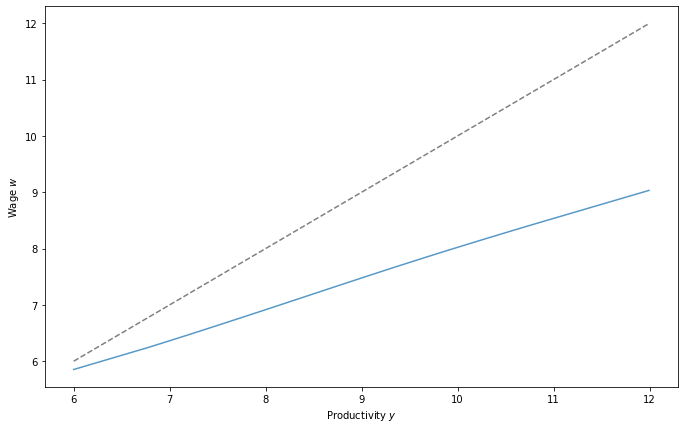

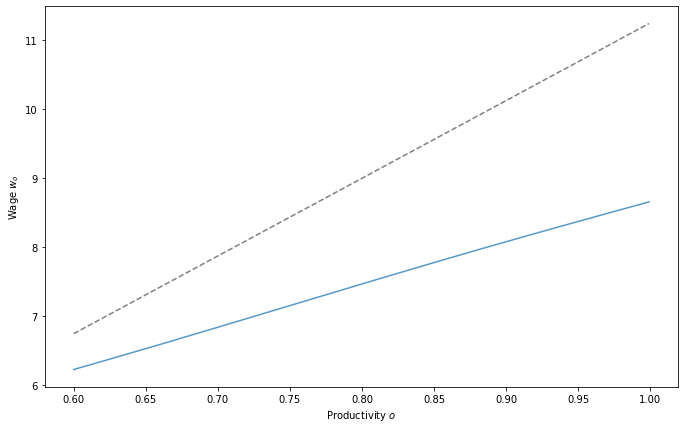

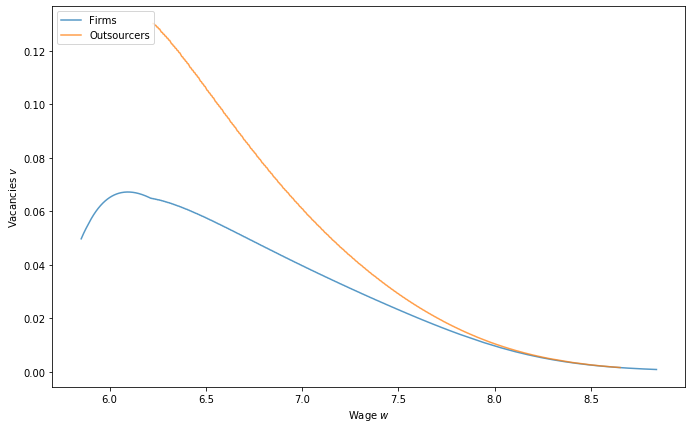

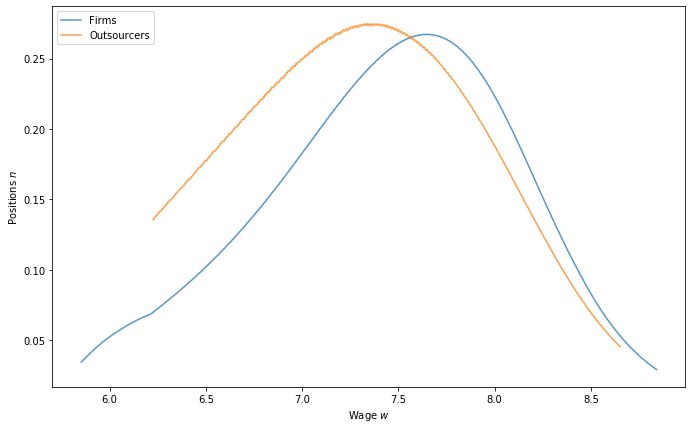

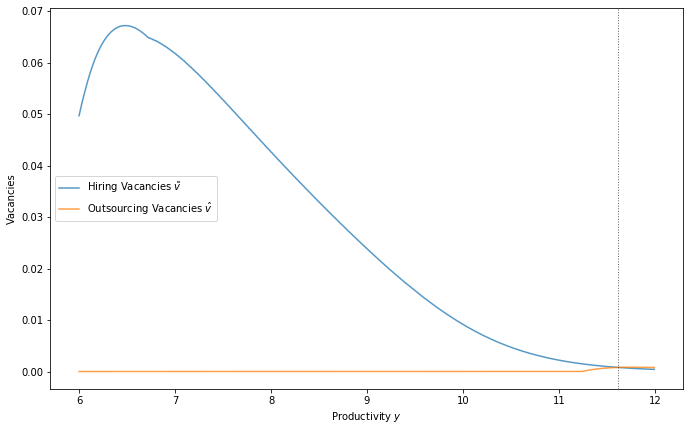

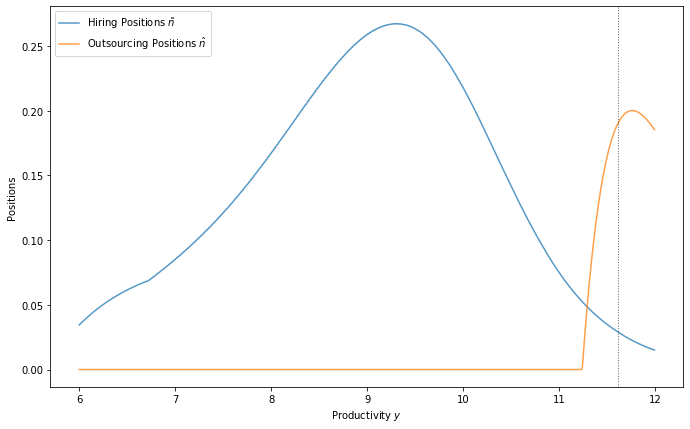

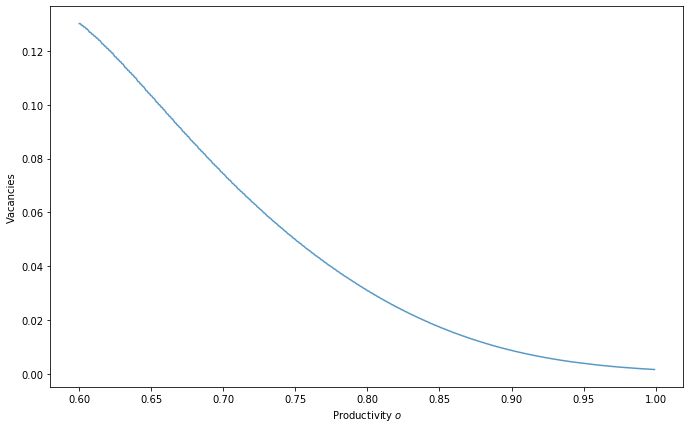

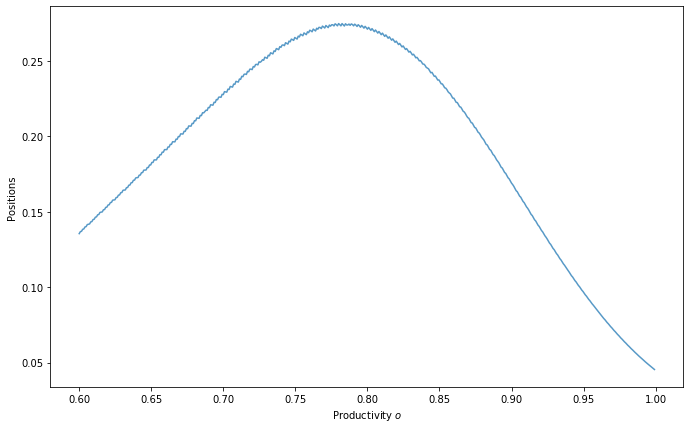

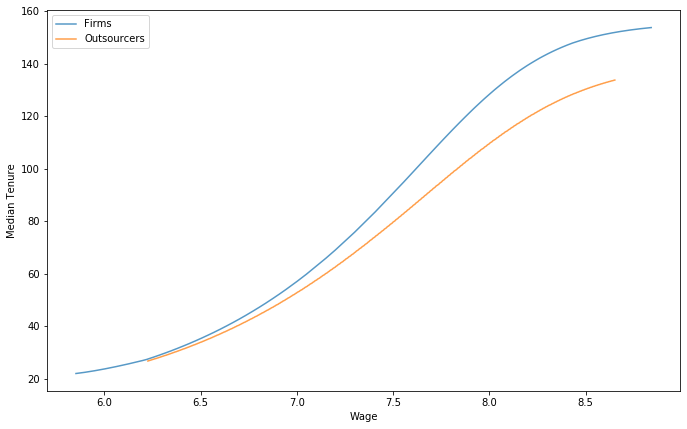

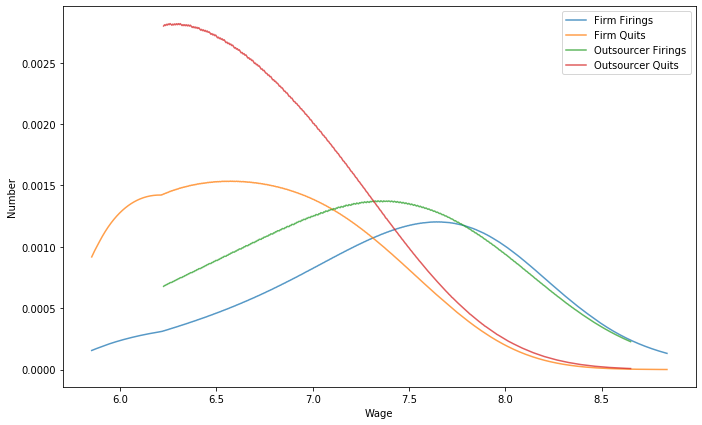

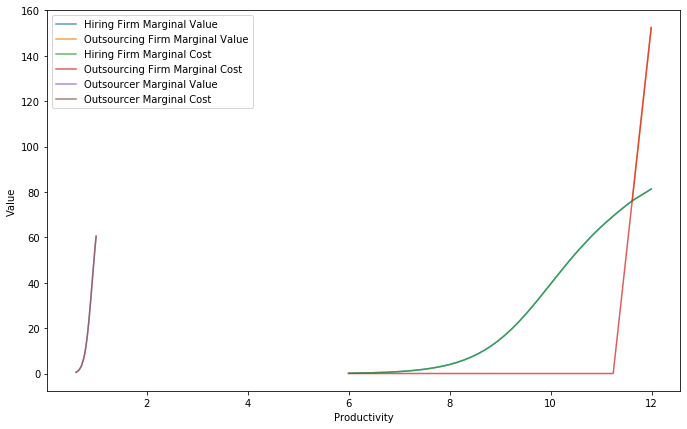

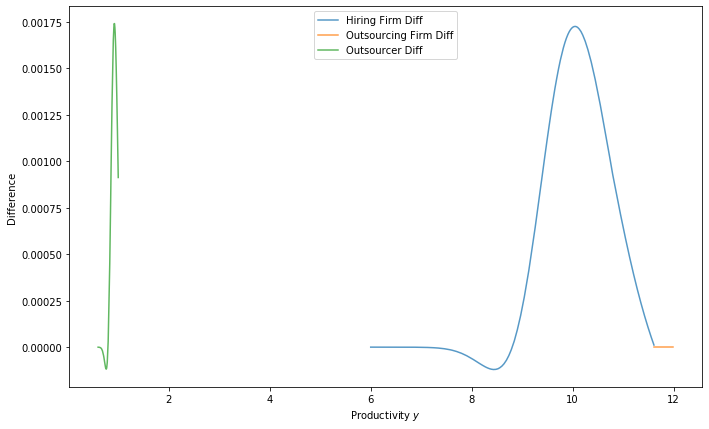

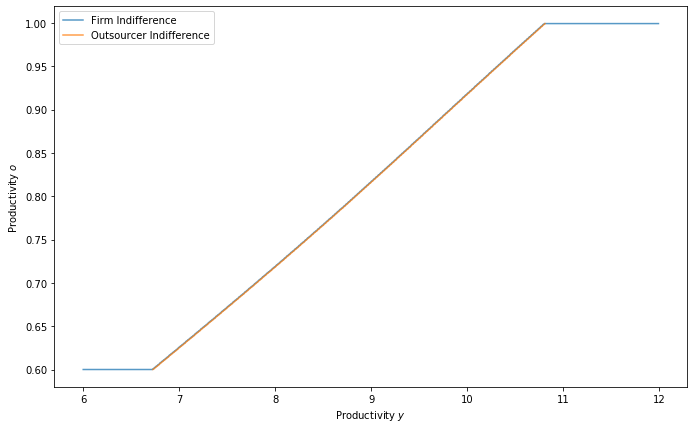

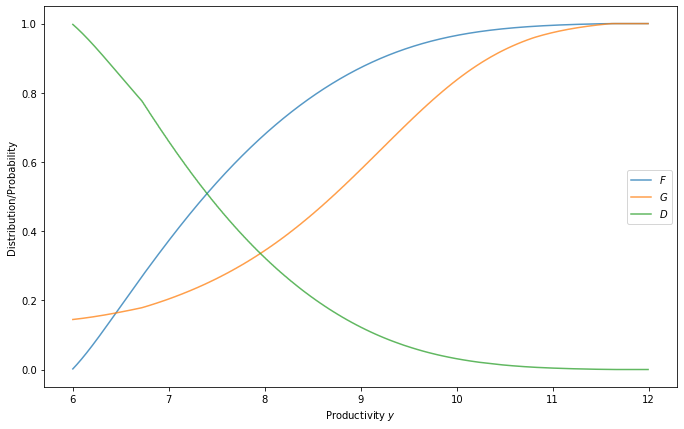

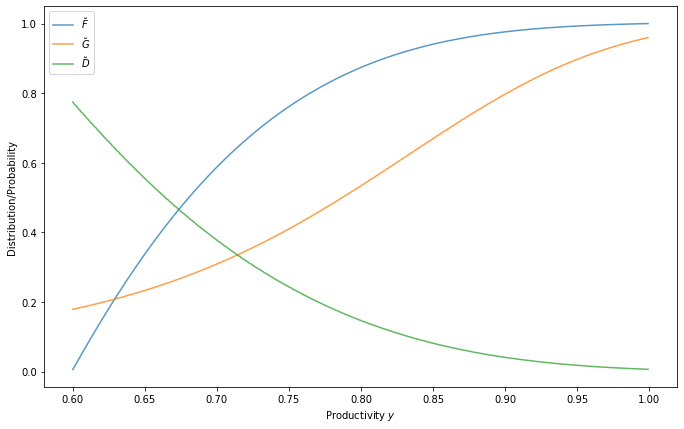

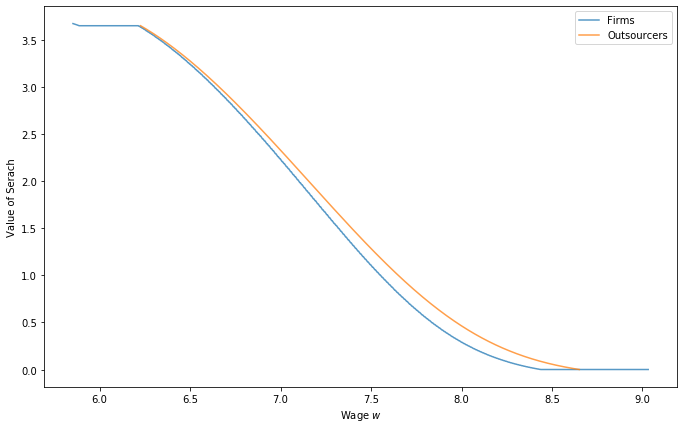

In [28]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.6
o_max = 1.0
b = y_min * .4 
y_grid_size = 1000
# y_grid_size = 8000
o_grid_size = 500
gamma = 2
gamma_o = 2
k_grid = np.logspace(0, 5, y_grid_size, endpoint = False)
k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 6
p_high = 12
tol = 1e-4
max_iter = 20
tol_i = 1e-4
max_iter_i = 2e4
slow_i = 5e-2
print_skip = 5
verbose = True

save = False

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

(v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)


folder=r'C:/Users/spspi/Dropbox/Documents/Outsourcing/Figures/Python Simulations/Example 2'
file=r'/'
f = None

if save:
    f = open(folder + file + "Details.txt", "w")
    k_names = """
    k_grid = np.logspace(0, 5, y_grid_size, endpoint = False) \n 
    k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False) \n    
    """
    save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names)
    
    
list_facts(ooj, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=f)

graph_results(ooj, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid,
              n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, 
              save=save, folder=folder, file=file)

if save:
    f.close()

error is 0.0001, went through 1 iterations
y_hat is 11.3536, y_hat_new is 11.3538
The difference in theta and theta_new is 0.0000


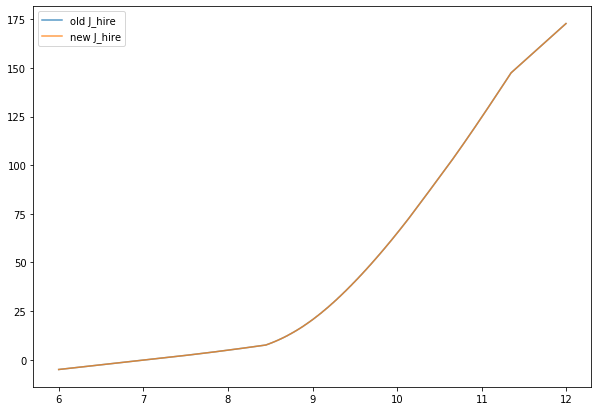

The indifferent firm is y_hat = 11.35$. Price of outsourcing is 10.62.
Unemployment is 4.78. According to LoM, should be 4.81
Workers match with probability 9.41. Firms/Outsourcers match with probability 42.49
Total vacancies searching for workers are 0.0317. Theta is 0.2216
65 percent of vacancies searching for workers are from outsourcers, 51 percent of postions outsourced
The ue rate is 0.0941, the ee rate is 0.0060,  and 44.142202 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms largest error = 0.004113 at position 891 
 Outsourcing firms largest error = 0.014720 at position 915
 Outsourcer largest error = 0.013364 at position 234


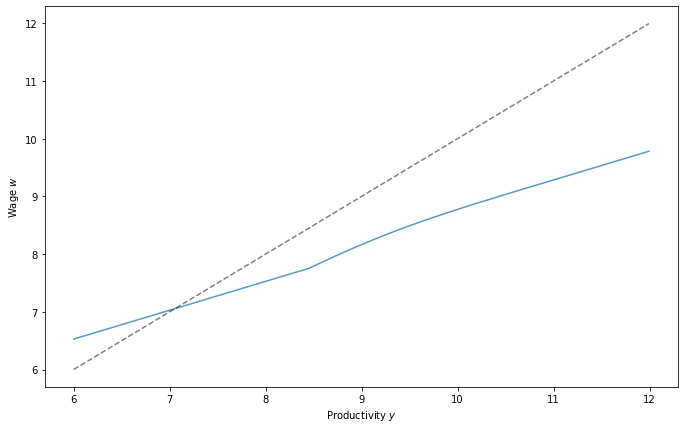

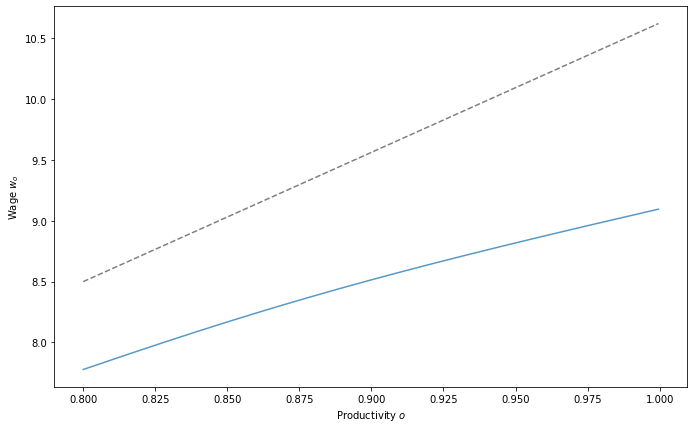

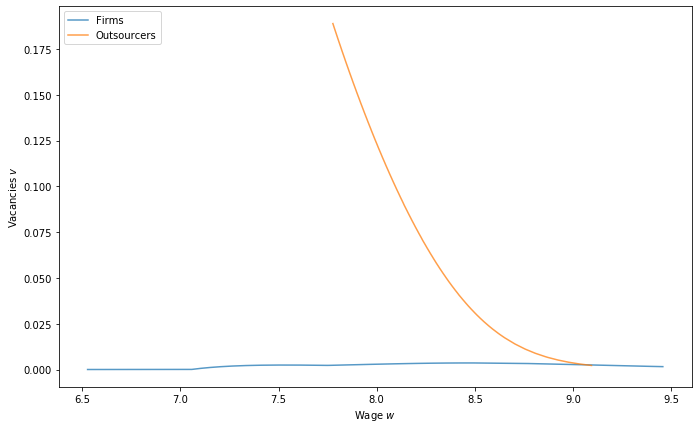

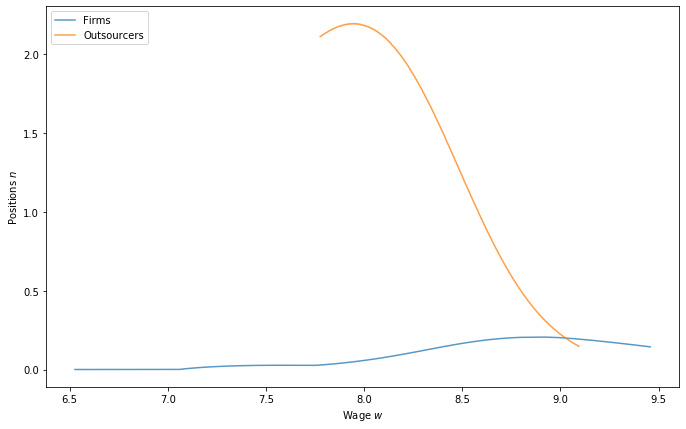

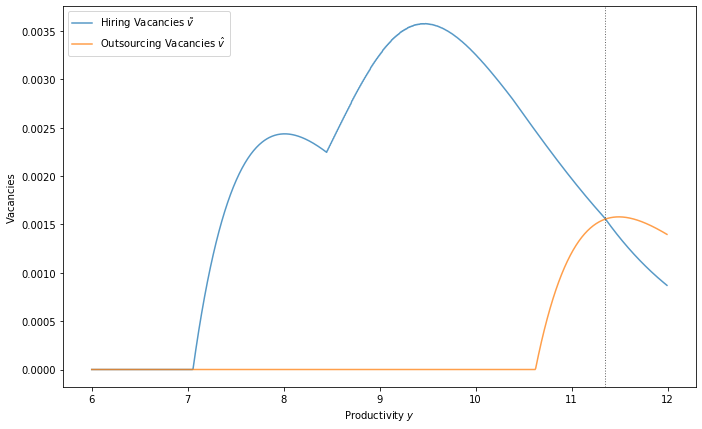

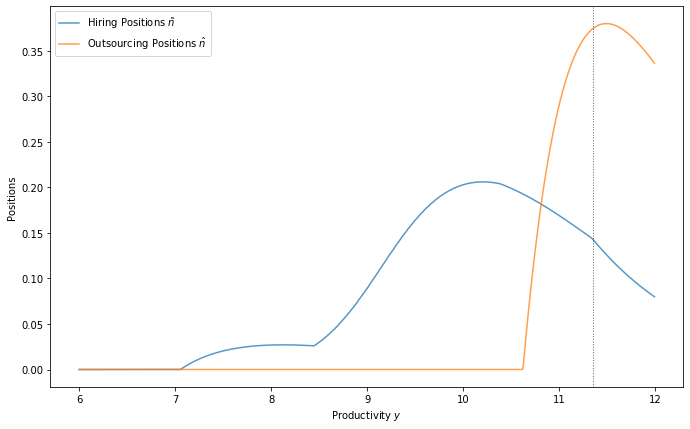

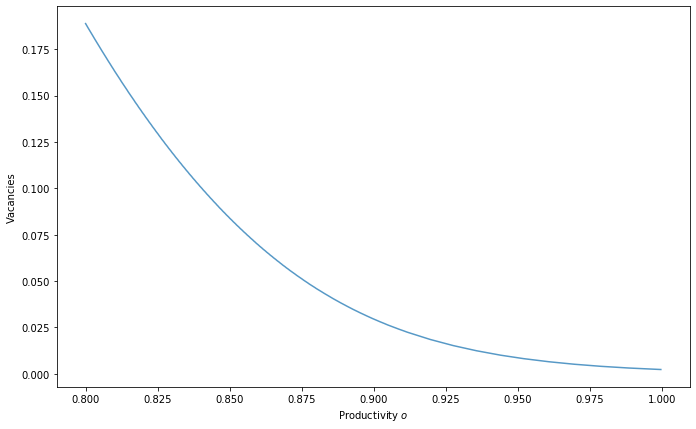

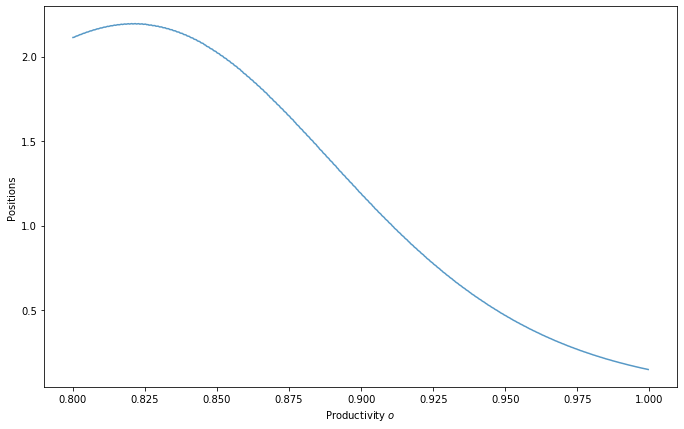

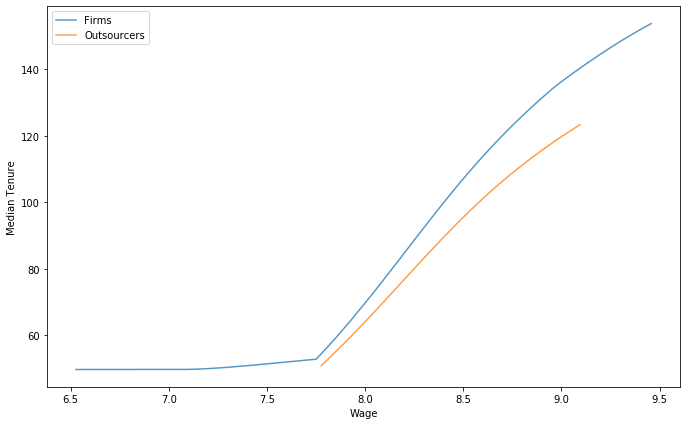

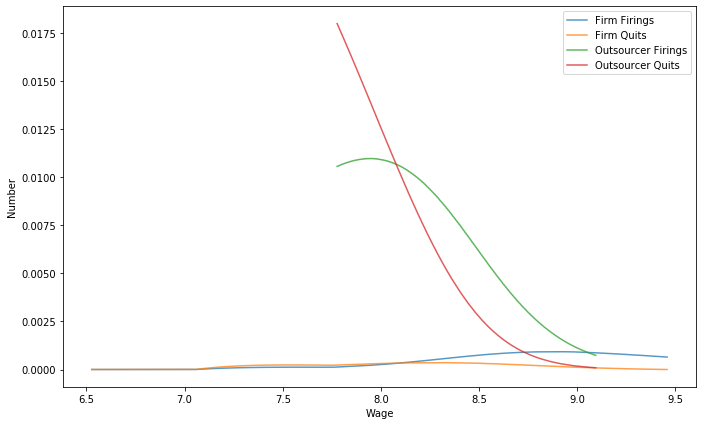

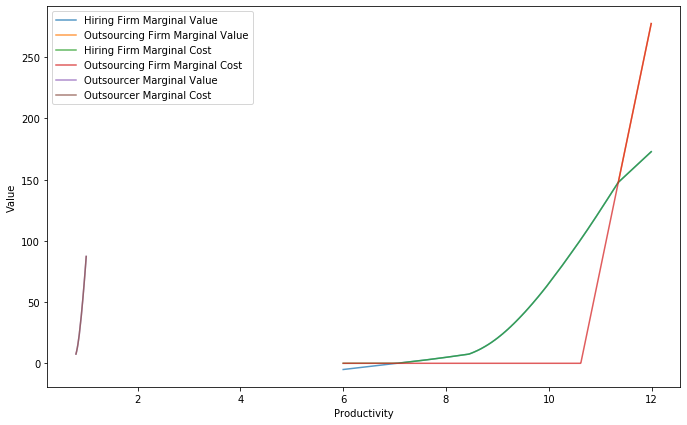

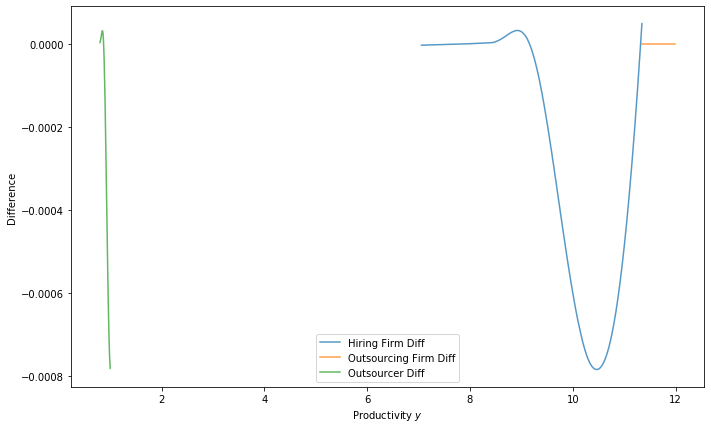

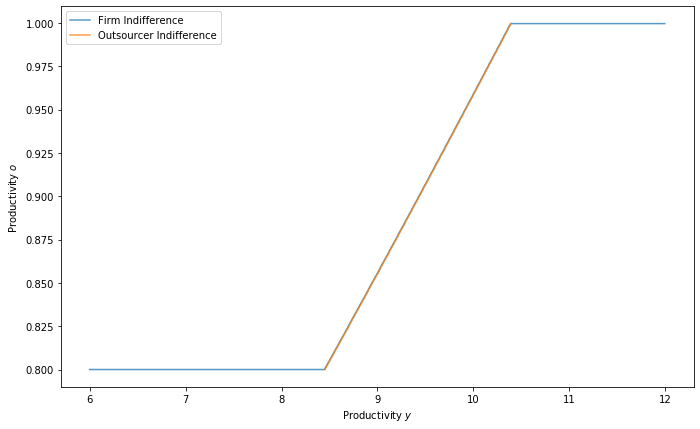

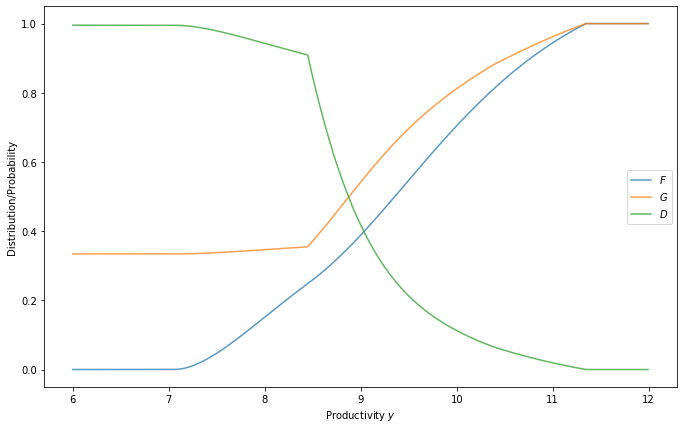

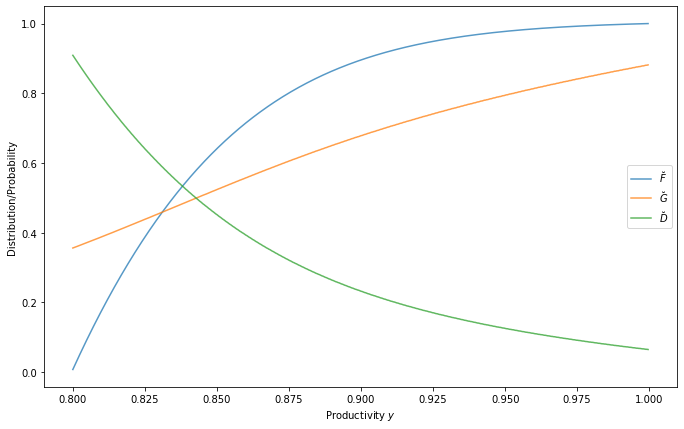

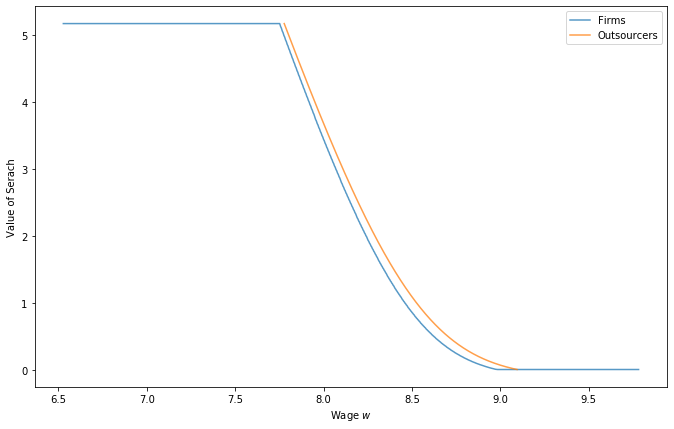

In [52]:
tol = 1e-4
max_iter = 1e4
slow = 1e-1
verbose = True

(v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
 n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new) = solve_given_p(
    ooj, p, v_tilde_grid, v_hat_grid, v_o_grid, n_tilde_grid, n_hat_grid,
    n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose
)

list_facts(ooj, v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
               n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

graph_results(ooj, v_tilde_grid_new, v_hat_grid_new, v_o_grid_new, n_tilde_grid_new,
              n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)



In [ ]:
iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# (theta, G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_tilde_grid_new, v_o_grid_new, n_tilde_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

q = ooj.q
y_grid, o_grid = ooj.y_grid, ooj.o_grid

J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
mc_tilde = c(v_tilde_grid)    

J_out = (y_grid - p) / (r + delta_hat)
mc_hat = c(v_hat_grid)

O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
mc_o = c_o(v_o_grid) 

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
ax.plot(y_grid, J_out, alpha=0.75, label="Outsourcing Firm Marginal Value")
ax.plot(y_grid, mc_tilde, alpha=0.75, label="Hiring Firm Marginal Cost")
ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
ax.set(xlabel="Productivity $y$", ylabel="Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, v_tilde_grid, alpha=0.75, label="Vacancies")
ax.plot(y_grid, c_inv(J_hire), alpha=0.75, label="VIB Hiring Firm Marginal Value")
ax.plot(o_grid, v_o_grid, alpha=0.75, label="O Vacancies")
ax.plot(o_grid, c_o_inv(O), alpha=0.75, label="VIB O Marginal Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid[:y_hat], v_tilde_grid[:y_hat] - c_inv(J_hire)[:y_hat], alpha=0.75, label="Hiring Firm Diff")
ax.plot(y_grid[y_hat:], v_hat_grid[y_hat:] - c_inv(J_out)[y_hat:], alpha=0.75, label="Outsourcing Firm Diff")
ax.plot(o_grid, v_o_grid - c_o_inv(O), alpha=0.75, label="O Diff")
ax.legend(loc="best")

plt.show()

In [47]:
iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_tilde_grid, v_o_grid, n_tilde_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

n_o_ss = v_o_grid * ooj.q(theta) * G_o_grid / (delta_o + D_o_grid - delta_o * D_o_grid)

n_o_grid_new = n_o_grid
for i in range(1000):
    n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + ooj.q(theta) * G_o_grid * v_o_grid

# max(np.abs(n_o_grid_new - n_o_grid))
n_o_grid_new[0] - n_o_grid[0]
n_o_ss[0] - n_o_grid[0]

0.001059769849188541

In [285]:
# This is a simple model (without outsourcers) with on the job search.
# Builds on the file in Baseline.

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize
from IPython.core.debugger import set_trace
    
class BaselineOnJob:    
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    xi is probability searh on the job
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    rm is the Reimann Sum multiplier to estimate integrals
    gamma is steepness of marginal cost, k_grid is distribution of firm entry costs
    q is matching function of firms
    ell is matching function of workers    
    """
    
    def __init__(self, B, b, delta, xi, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid):
        
        self.B, self.b, self.delta, self.xi = B, b, delta, xi 
        self.eta, self.gamma, self.k_grid = eta, gamma, k_grid
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size 
        self.rm = (y_max - y_min) / y_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2))
        
# Given a class, set up functions
def operator_factory(boj):
    "The functions to solve a case of BaselineOnJob"
    
    B, r, b, delta, xi = boj.B, boj.r, boj.b, boj.delta, boj.xi
    eta, gamma, k_grid = boj.eta, boj.gamma, boj.k_grid
    y_grid, y_grid_size = boj.y_grid, boj.y_grid_size
    q, ell = boj.q, boj.ell
    rm = boj.rm
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma

    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        c_grid[c_grid < 0] = 0
        return (c_grid / gamma / k_grid)**(1 / (gamma - 1))
    
    # Given v_grid and n_grid find theta, the firms a worker would leave for F_bar_grid
    # workers a firm can hire G_grid, and wages w_grid
    @njit()
    def make_grids(v_grid, n_grid):
        # Define aggregate populations
        u = 1 - np.sum(n_grid * rm)
        v = np.sum(v_grid * rm)
        s = (u + xi * (1 - u))
        
        # Calculate theta
        theta = v / s
        
        # Calculate distributions 
        F_grid = np.cumsum(v_grid * rm) / v
        F_bar_grid = 1 - F_grid
        f_grid = v_grid / v
        G_grid = (u + xi * np.cumsum(n_grid * rm)) / s
        
        # Calculate value of search
        search = c(v_grid) / G_grid * f_grid * rm
        Gamma_U = eta / (1 - eta) * ell(theta) / q(theta) * np.sum(search)
        # This goes from y to y_bar
        Gamma = eta / (1 - eta) * ell(theta) / q(theta) * np.cumsum(search[::-1])[::-1]
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma)        
        
        return theta, F_bar_grid, G_grid, w_grid

    # Find next v_grid and n_grid
    @njit()
    def iterate(v_grid, n_grid):
        
        theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
        
        # Find out how many vacancies each firm wants to create using firms' FOC
        v_grid_new = c_inv(
            (y_grid - w_grid) * q(theta) * G_grid / (r + delta + (1 - delta) * xi * ell(theta) * F_bar_grid)
        )
        
        # Use LOM to guess n_grid_new
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * F_bar_grid) * n_grid + q(theta) * G_grid * v_grid
        
        return v_grid_new, n_grid_new
    
    return iterate, make_grids, C, c, c_inv

def solve_model(boj, tol=1e-4, max_iter=1000, verbose=True, print_skip=25, slow=1e-3):
    
    iterate, _, _, _, _ = operator_factory(boj)
    
    # Set up initial guesses and loop parameters
    size = boj.y_grid_size
    v_grid = np.ones(size) / size
    n_grid = np.ones(size) / size
    i = 0
    err = tol + 1    
    
    # Update v_grid and u each period
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid 
        n_grid = slow * n_grid_new + (1 - slow) * n_grid 
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, n_grid_new      
    
# Create a function to graph results
def graph_results(boj, v_grid, n_grid, save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Baseline OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from boj
    _, make_grids, C, c, c_inv = operator_factory(boj)
    theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
    r, delta, xi, q, ell = boj.r, boj.delta, boj.xi, boj.q, boj.ell
    k_grid = boj.k_grid
    y_grid = boj.y_grid
    
    # Graph wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Wages v Productivity.pdf')
    else:
        plt.show()  
        
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, n_grid, alpha=0.75)
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacanicies $v$")
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.set(xlabel="Productivity $y$", ylabel="Size")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Vacancies and Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by productivity
    p_stay = (1 - delta) * (1 - xi * ell(theta) * F_bar_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, median_tenure, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Median Tenure")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by productivity
    firings = delta * n_grid
    quits = (1 - delta) * xi * ell(theta) * F_bar_grid * n_grid
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, firings, alpha=0.75, label="Firings")
    ax.plot(y_grid, quits, alpha=0.75, label="Quits")
    ax.set(xlabel="Productivity $y$", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one
    dJ_dn = ((1 + r) * (y_grid - w_grid) 
             / (r + delta + (1 - delta) * xi * ell(theta) * F_bar_grid))
    mc = (1 + r) * c(v_grid) / (q(theta) * G_grid)    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, dJ_dn, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Firm M Value and Cost.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm minus the marginal cost of aquiring one
    # Where v > 0
    diff = dJ_dn - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], diff[v_grid > 0], alpha=0.75, label="Firm Marginal Value")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
#     ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Firm M Value minus Cost.pdf')
    else:
        plt.show()
        
    # Graph the distributions of vacancies F and job seekers G   
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, 1 - F_bar_grid, alpha=0.75, label="$F$")
    ax.plot(y_grid, G_grid, alpha=0.75, label="G")
    ax.set(xlabel="Productivity $y$", ylabel="Density")
    ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Distributions.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(boj, v_grid, n_grid):
    
    _, make_grids, _, _, _ = operator_factory(boj)
    delta, xi, q, ell = boj.delta, boj.xi, boj.q, boj.ell
    rm = boj.rm
    
    theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
    
    u = 1 - np.sum(n_grid * boj.rm)
    u_lom = delta / (delta + ell(theta))
    print(f"Unemployment is {u:.4f}. According to LoM, should be {u_lom:.4f}")
    print(f"Workers match with probability {ell(theta):.4f}. Firms match with probability {q(theta):.4f}")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = xi * ell(theta) * np.sum(n_grid * F_bar_grid * rm) / np.sum(n_grid * rm)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f}, and {per_from_u:0f} of new jobs are from unemployment")

Error at iter 20000 is 1.4124797991788007e-05
Error at iter 40000 is 1.5700819216979411e-07
Converged in 52241 iterations
Unemployment is 0.2107. According to LoM, should be 0.0542
Workers match with probability 0.0786. Firms match with probability 1.0000
The ue rate is 0.0786, the ee rate is 0.0031, and 87.226135 of new jobs are from unemployment


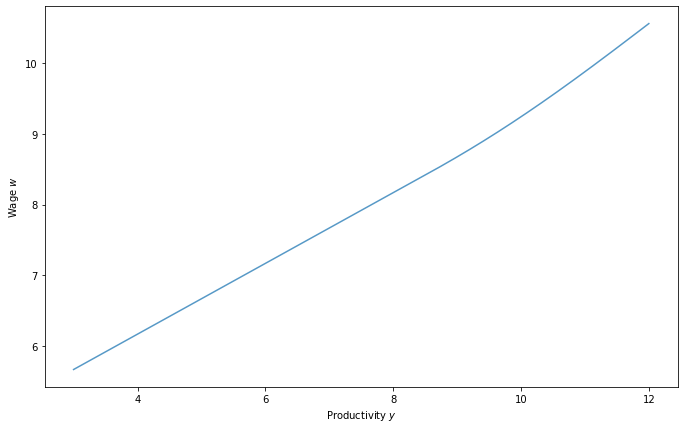

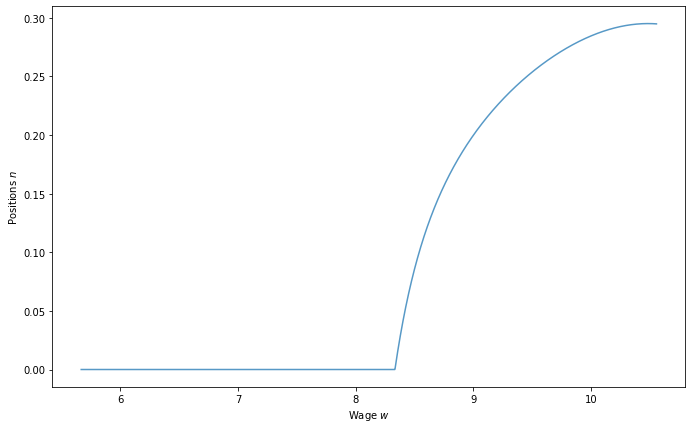

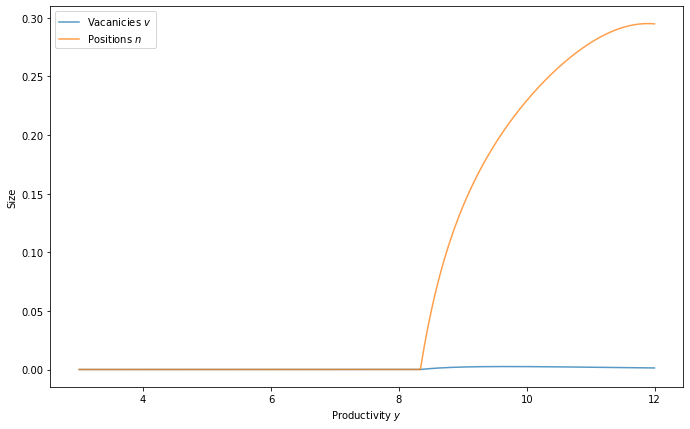

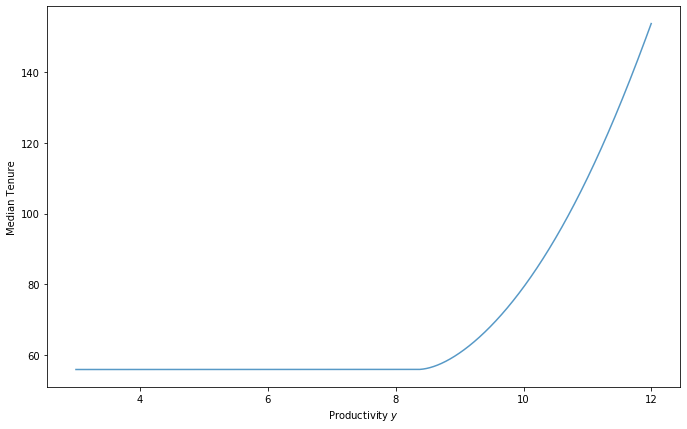

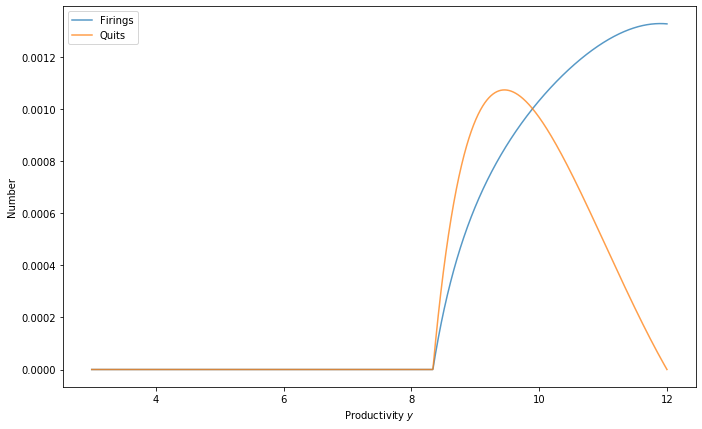

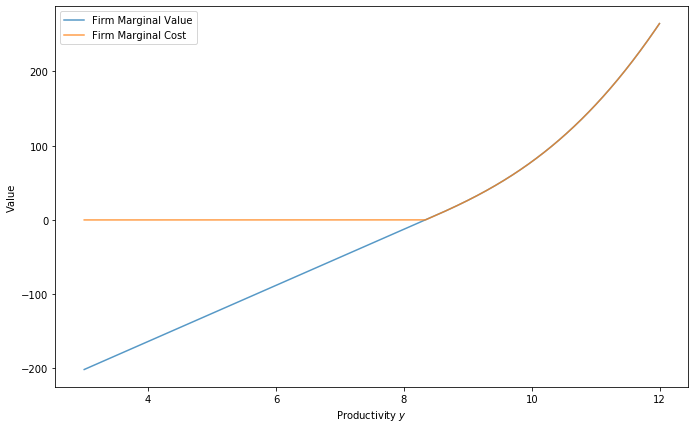

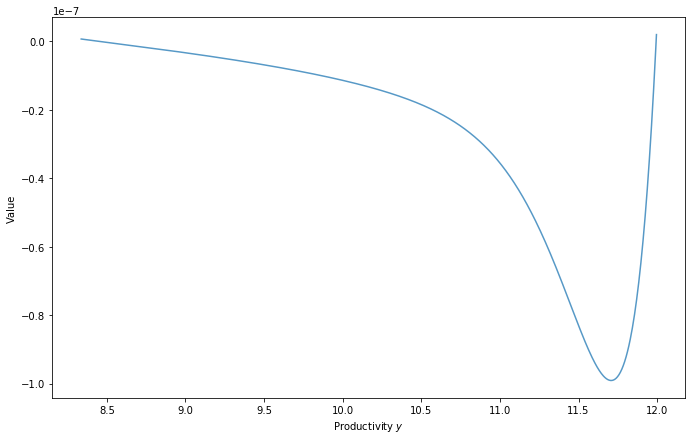

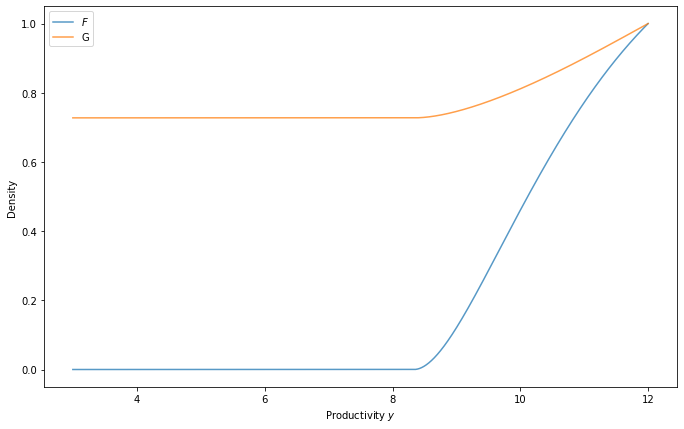

In [286]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
xi = .1
# xi = 0
eta = 0.5
phi = 5e-1 
y_min = 3
y_max = 12
b = y_min * .4 
y_grid_size = 2000
# y_grid_size = 8000
gamma = 2
# gamma = 1.5
k_grid = np.logspace(1, 5, y_grid_size, endpoint = False)
# k_grid = 5e2
# k_grid = np.linspace(1, 15, y_grid_size, endpoint = False)**2

boj = BaselineOnJob(B, b, delta, xi, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid)

v_grid, n_grid = solve_model(boj, tol=1e-8, print_skip=2e4, max_iter=2e5, slow=5e-2)

list_facts(boj, v_grid, n_grid)

graph_results(boj, v_grid, n_grid)

[0.92286041 0.92290624 0.92295205 ... 0.9699995  0.96999975 0.97      ] [ 8.63441112  8.63975637  8.64510429 ... 22.75618816 22.75638078
 22.75657306]


In [3]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize, int32, float64
from IPython.core.debugger import set_trace

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):           
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate theta and pi 
        v_sum = v_tilde + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
        f_grid = v_grid / v_tilde
        f_grid[y_hat:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_grid)
        n_temp[y_hat:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        v_grid_new = np.empty(y_grid_size)
        n_grid_new = np.empty(y_grid_size)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
#         y_hat_new = min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1)
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = max(y_diff, y_zero)
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new[:y_hat] = c_inv(J_hire)[:y_hat]
        
        # Outsourcing firms (above y_hat)
        v_grid_new[y_hat:] = c_inv(J_out)[y_hat:]
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_temp = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        n_grid_new[:y_hat] = n_temp[:y_hat]
        
        # Outsourcing firms
        n_grid_new[y_hat:] = (1 - delta_hat) * n_grid[y_hat:] + v_grid_new[y_hat:]
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
                
        # Use these to find new indecision rules
#         R_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U[i] - W_o_min_U)) for i in np.arange(y_grid_size)]
#         )
#         R_o_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U - W_o_min_U[i])) for i in np.arange(o_grid_size)]
#         )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS(n_grid, n_o_grid, y_hat):
        QD = np.sum(n_grid[y_hat:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        return QD, QS
    
    return iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
    while i < max_iter and err > tol:
        (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
         y_hat_new, R_grid_new, R_o_grid_new) = iterate(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v, err_v_o, err_n, err_n_o)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
#         n_grid = n_grid_new
#         n_o_grid = n_o_grid_new
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1/5 if greater/less (depend on size)
#         y_pos = 1 * (y_hat_new > y_hat) + 4 * (y_hat_new - y_hat > 50)
#         y_neg = 1 * (y_hat_new < y_hat) + 4 * (y_hat_new - y_hat < -50)
#         y_hat = y_hat + y_pos - y_neg
        
#         R_pos = 1 * (R_grid_new > R_grid) + 4 * (R_grid_new - R_grid > 50)
#         R_neg = 1 * (R_grid_new < R_grid) + 4 * (R_grid_new - R_grid < -50)
#         R_grid = R_grid + R_pos - R_neg
        
#         R_o_pos = 1 * (R_o_grid_new > R_o_grid) + 4 * (R_o_grid_new - R_o_grid > 50)
#         R_o_neg = 1 * (R_o_grid_new < R_o_grid) + 4 * (R_o_grid_new - R_o_grid < -50)
#         R_o_grid = R_o_grid + R_o_pos - R_o_neg
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
        y_hat = y_hat + 1 * (y_hat_new > y_hat) - 1 * (y_hat_new < y_hat)
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)

    if verbose:
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        (theta_new, G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new")
        ax.legend()
        plt.show()       
        
    return (
        v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
            ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Excess Demand for price {p} is {QD - QS:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2
        
#         # Initial guesses (reset initially)
#         if j <= 5:
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#             y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
              
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
)
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        ed = QD - QS
        err = np.abs(ed)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ed > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_grid[y_hat]}"
            )
            
        j += 1
        
#     # Run one more loop with 10 times the iterations, 1/100 the tolerance
#     if verbose:
#         print(
#             f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
#             f"y_hat is {y_grid[y_hat]}\n One more loop..."
#         )
            
#     v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
#     ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid,
#         tol_i / 100, max_iter_i * 10, slow_i
# )
#     QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
#     ed = QD - QS
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ed:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ed:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], v_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], n_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies $v$")
#     ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
#     ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], median_tenure[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], firings[:y_hat], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_hat], quits[:y_hat], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    J_out = (y_grid - p) / (r + delta_hat)
    mc = c(v_grid)    
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_hat:], J_out_diff[y_hat:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v_tilde = np.sum(v_grid[:y_hat] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\breve{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\breve{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\breve{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
    
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    print(f"The indifferent firm is y_hat = {y_grid[y_hat]:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o)
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_hat] * D_grid[:y_hat] * rm) / np.sum(n_grid[:y_hat] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.2f}, the ee rate is {ee:.2f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss_tilde = v_grid[:y_hat] * q(theta) * G_grid[:y_hat] / delta
    n_tilde = n_grid[:y_hat]
    if y_hat > min(y_grid):
        err_tilde = max(np.abs(n_ss_tilde - n_tilde))
        err_tilde_at = np.argmax(np.abs(n_ss_tilde - n_tilde))
    else:
        err_tilde = 0
        err_tilde_at = 0
    
    n_ss_hat = v_grid[y_hat:] / delta_hat
    n_hat = n_grid[y_hat:]
    if y_hat < max(y_grid):
        err_hat = max(np.abs(n_ss_hat - n_hat))
        err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat))
    else:
        err_hat = 0
        err_hat_at = 0
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / delta_o
    n_o = v_o_grid
    err_o = max(np.abs(n_o_ss - n_o))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms large error = {err_tilde:.6f} at position {err_tilde_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )                       

Excess Demand for price 6 is 10633.7864; QS is 0.0045; QD is 10633.7909
Excess Demand for price 12 is -0.0508; QS is 0.0508; QD is 0.0000
Excess Demand at iter 0 is 96.2567; price is 9.0000; QS is 0.0007; QD is 96.2574 y_hat is 9.222
Excess Demand at iter 5 is -0.0155; price is 11.5312; QS is 0.0224; QD is 0.0069 y_hat is 11.994
Excess Demand at iter 10 is -0.0126; price is 11.4697; QS is 0.0206; QD is 0.0080 y_hat is 11.994
Failed to Converge. Excess Demand is 0.0671; price is 11.4684;  QS is 0.0204; QD is 0.0875
The indifferent firm is y_hat = 11.84$. Price of outsourcing is 11.47.
Unemployment is 12.53. According to LoM, should be 7.19
Workers match with probability 5.82. Firms/Outsourcers match with probability 68.68
Total vacancies searching for workers are 0.0180. Theta is 0.0848
3 percent of vacancies searching for workers are from outsourcers, 3 percent of postions outsourced
The ue rate is 0.06, the ee rate is 0.01,  and 59.786348 of new jobs are from unemployment
Checking if 

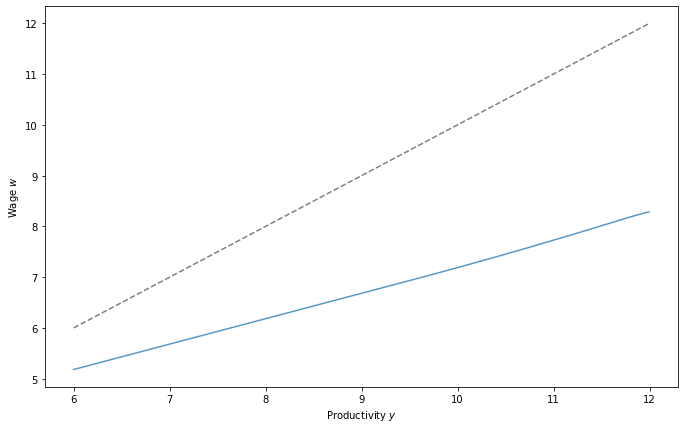

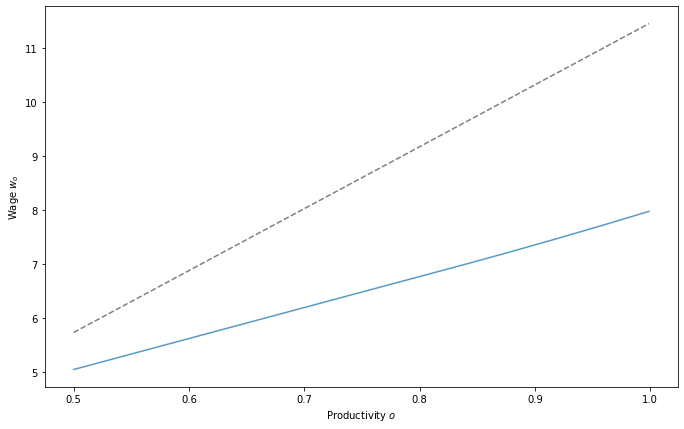

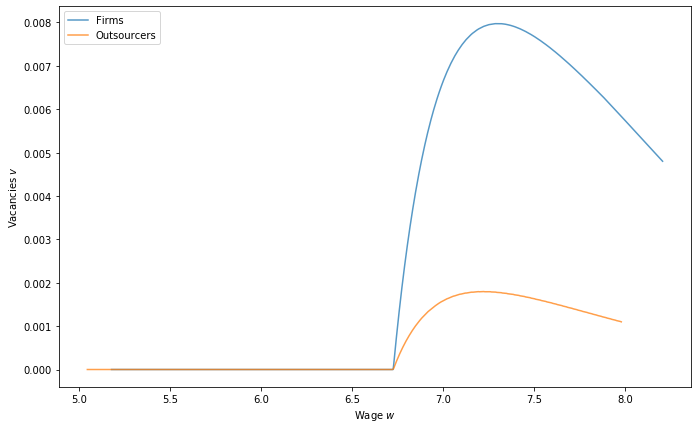

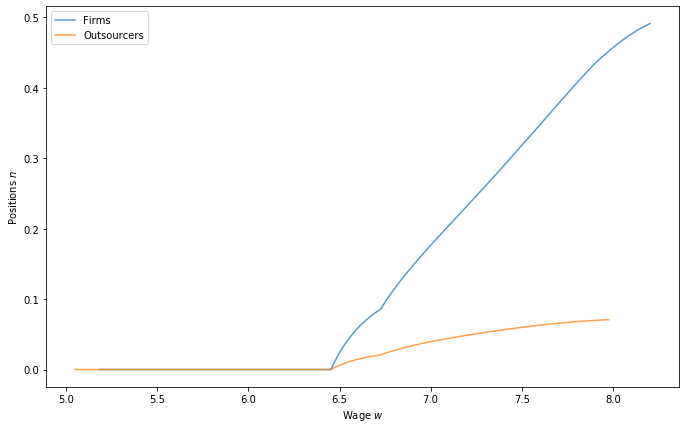

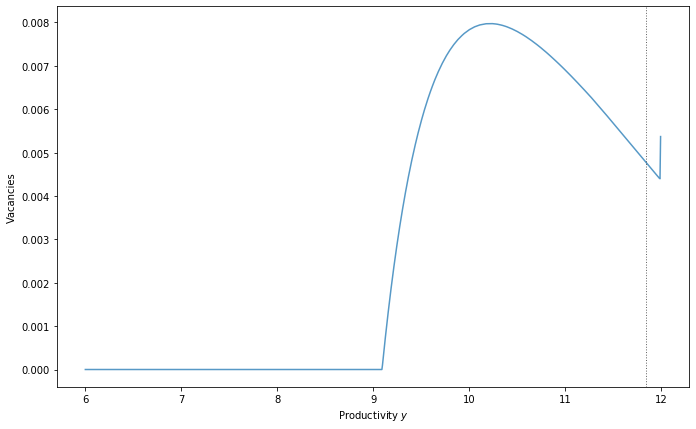

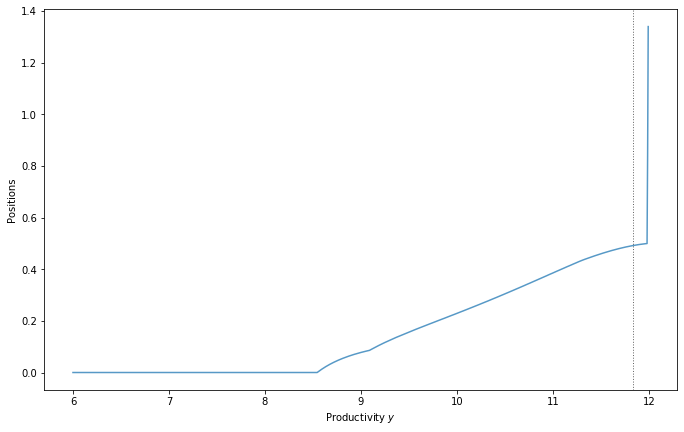

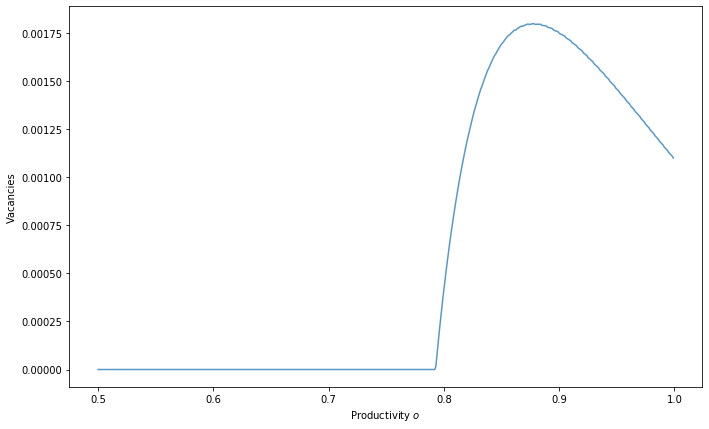

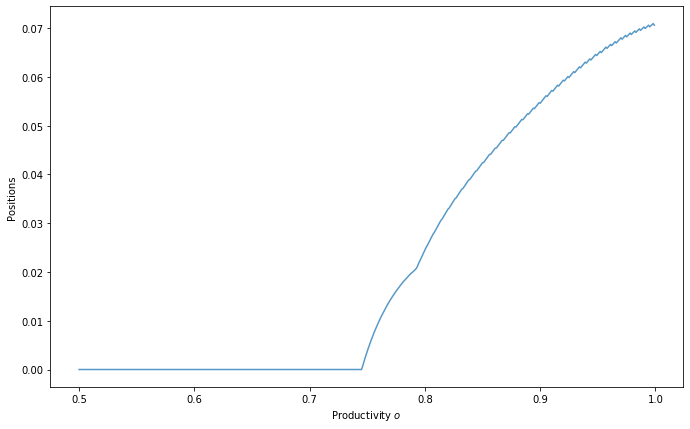

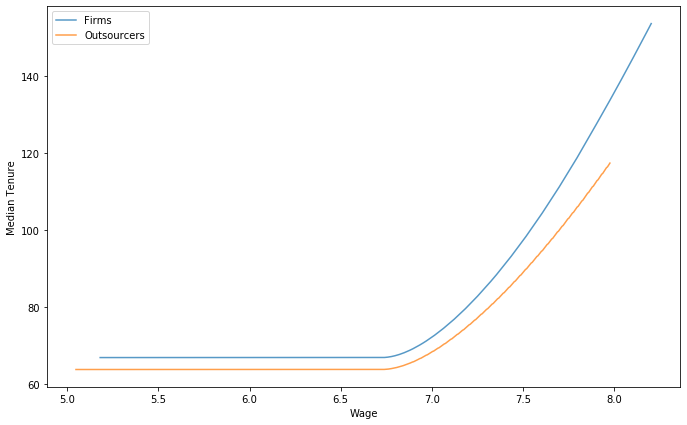

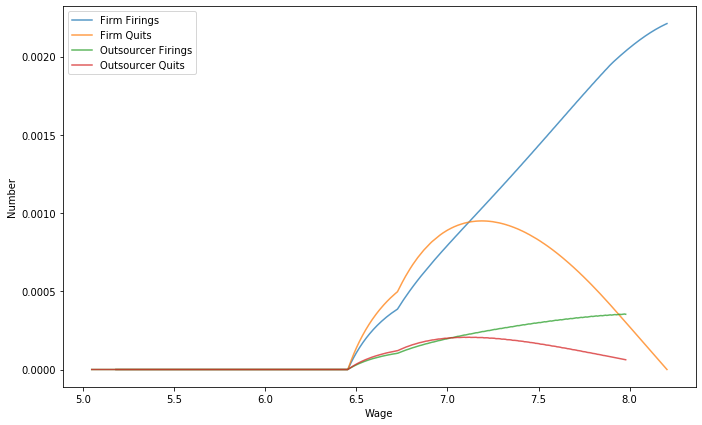

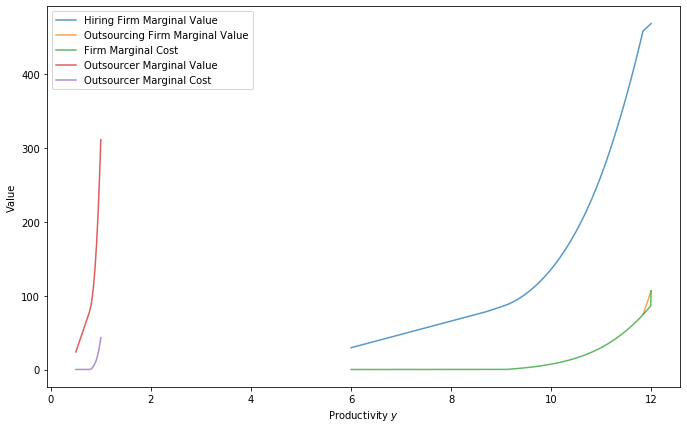

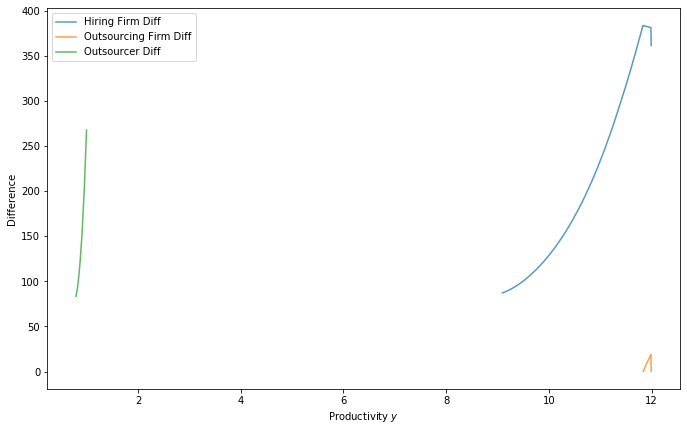

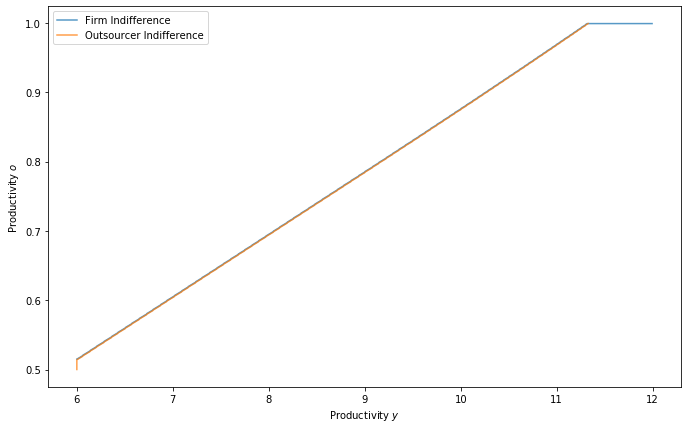

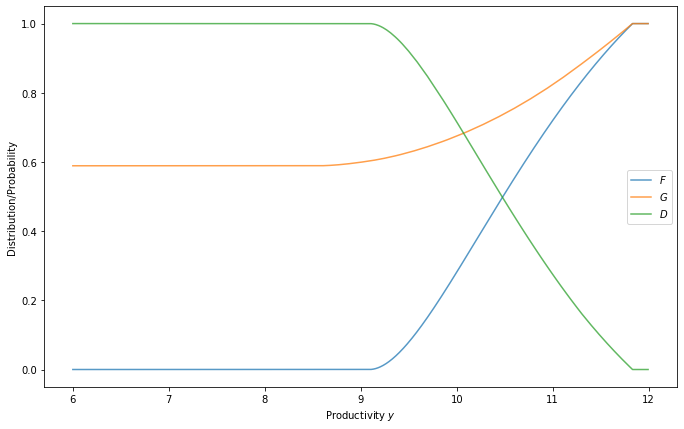

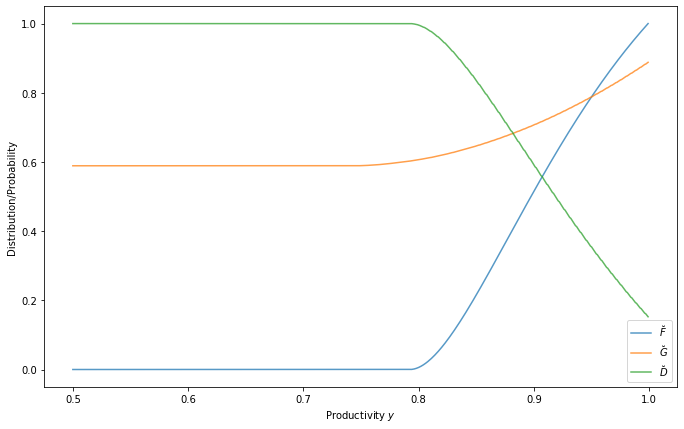

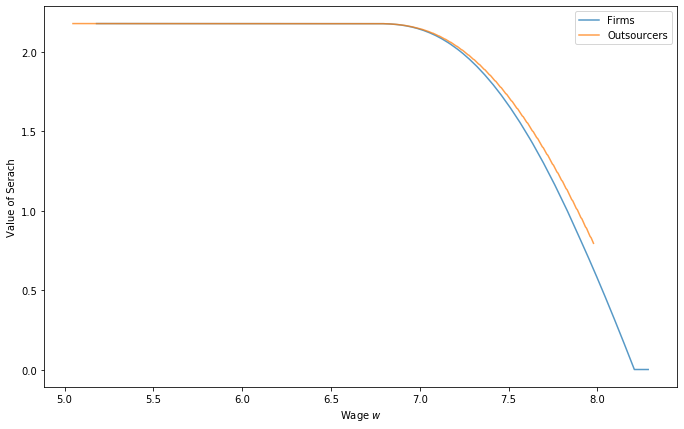

In [4]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.5
o_max = 1.0
b = y_min * .4 
y_grid_size = 1000
# y_grid_size = 8000
o_grid_size = 500
gamma = 2
gamma_o = 2
k_grid = np.logspace(0, 4, y_grid_size, endpoint = False)
k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 6
p_high = 12
tol = 1e-4
max_iter = 15
tol_i = 1e-4
max_iter_i = 3e4
slow_i = 5e-2
print_skip = 5
verbose = True

save = True

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p = find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
             save=save)

In [92]:
%debug

> <ipython-input-90-7e7ce390805f>(278)solve_given_p()
    276         (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
    277          y_hat_new, R_grid_new, R_o_grid_new) = iterate(
--> 278             v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    279         )
    280         err_v = np.max(np.abs(v_grid_new - v_grid))

ipdb> n_grid
array([5.59848004e-01, 5.60860001e-01, 5.61884123e-01, 5.62921801e-01,
       5.63973379e-01, 5.65039214e-01, 5.66119682e-01, 5.67215222e-01,
       5.68326342e-01, 5.69453567e-01, 5.70597350e-01, 5.71758092e-01,
       5.72936308e-01, 5.74132525e-01, 5.75347385e-01, 5.76581413e-01,
       5.77835142e-01, 5.79109145e-01, 5.80404010e-01, 5.81720330e-01,
       5.83058713e-01, 5.84419773e-01, 5.85804138e-01, 5.87212443e-01,
       5.88645336e-01, 5.90103473e-01, 5.91587525e-01, 5.93098169e-01,
       5.94636097e-01, 5.96202010e-01, 5.97796622e-01, 5.99420657e-01,
       6.01074854e-01, 6.02759961e-01, 6.04476741e-01, 6.06225969e-01

ipdb> v_grid
array([4.64062701e-03, 4.66459216e-03, 4.68929218e-03, 4.71487332e-03,
       4.74116300e-03, 4.76810250e-03, 4.79563462e-03, 4.82371504e-03,
       4.85231986e-03, 4.88139785e-03, 4.91084152e-03, 4.94055721e-03,
       4.97054930e-03, 5.00082142e-03, 5.03147765e-03, 5.06247825e-03,
       5.09378859e-03, 5.12541060e-03, 5.15734597e-03, 5.18959624e-03,
       5.22216280e-03, 5.25504693e-03, 5.28824982e-03, 5.32177262e-03,
       5.35561638e-03, 5.38978216e-03, 5.42427096e-03, 5.45908377e-03,
       5.49422160e-03, 5.52968541e-03, 5.56547621e-03, 5.60159500e-03,
       5.63804280e-03, 5.67482065e-03, 5.71192963e-03, 5.74937082e-03,
       5.78714536e-03, 5.82525441e-03, 5.86369919e-03, 5.90248095e-03,
       5.94160096e-03, 5.98106058e-03, 6.02086119e-03, 6.06100423e-03,
       6.10149120e-03, 6.14232364e-03, 6.18350317e-03, 6.22503144e-03,
       6.26691019e-03, 6.30932191e-03, 6.35246932e-03, 6.39599371e-03,
       6.43989701e-03, 6.48418117e-03, 6.52884826e-03, 6.5739004

ipdb> n_o_grid
array([6.68183578e-01, 6.66463636e-01, 6.64777812e-01, 6.63126782e-01,
       6.61512492e-01, 6.59934630e-01, 6.58394226e-01, 6.56893515e-01,
       6.55431832e-01, 6.54016246e-01, 6.52653555e-01, 6.51336488e-01,
       6.50064898e-01, 6.48841076e-01, 6.47667522e-01, 6.46546925e-01,
       6.45482136e-01, 6.44476171e-01, 6.43534853e-01, 6.42660852e-01,
       6.41860788e-01, 6.41140469e-01, 6.40505919e-01, 6.39964643e-01,
       6.39523720e-01, 6.39189825e-01, 6.38968476e-01, 6.38866138e-01,
       6.38886788e-01, 6.39031997e-01, 6.39302967e-01, 6.39707459e-01,
       6.40242599e-01, 6.40908321e-01, 6.41712359e-01, 6.42652391e-01,
       6.43722925e-01, 6.44928678e-01, 6.46280948e-01, 6.47756851e-01,
       6.49390954e-01, 6.51151007e-01, 6.53057368e-01, 6.55115933e-01,
       6.57296138e-01, 6.59640643e-01, 6.62139294e-01, 6.64766463e-01,
       6.67523675e-01, 6.70484525e-01, 6.73586548e-01, 6.76826138e-01,
       6.80204985e-01, 6.83724808e-01, 6.87438310e-01, 6.91422

ipdb> c


The indifferent firm is y_hat = 11.87$. Price of outsourcing is 11.44.
Unemployment is 7.19. According to LoM, should be 6.45
Workers match with probability 6.66. Firms/Outsourcers match with probability 60.09
Total vacancies searching for workers are 0.0183. Theta is 0.1108
29 percent of vacancies searching for workers are from outsourcers, 19 percent of postions outsourced
The ue rate is 0.07, the ee rate is 0.01,  and 43.378050 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.228368 at position 764 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 3.325461 at position 69


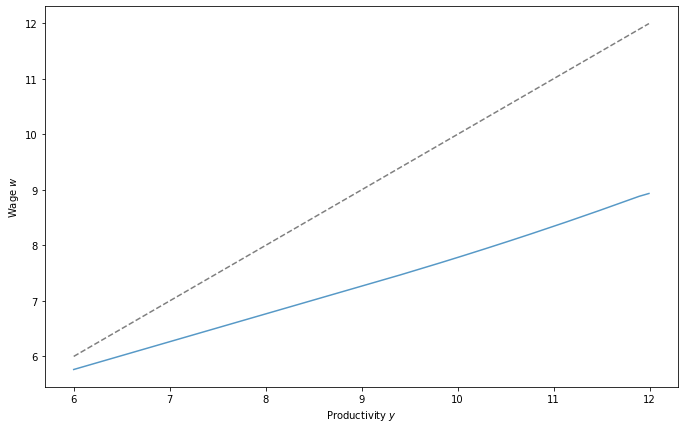

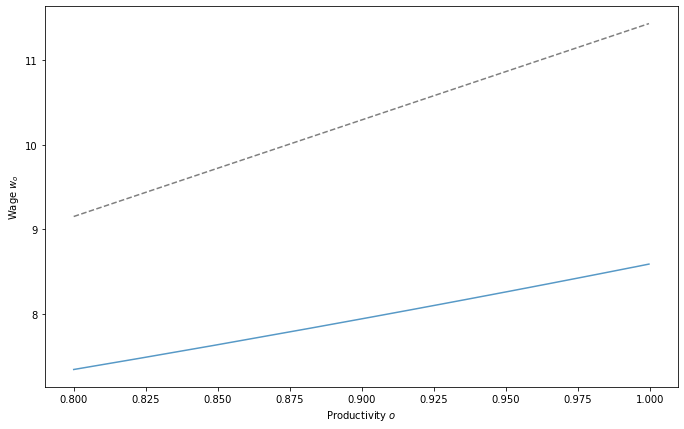

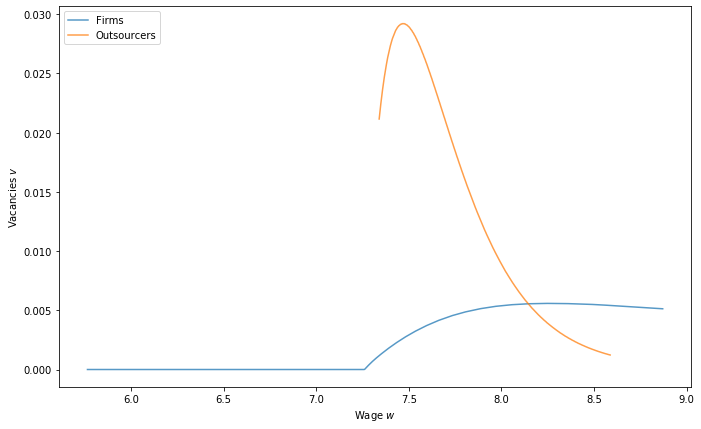

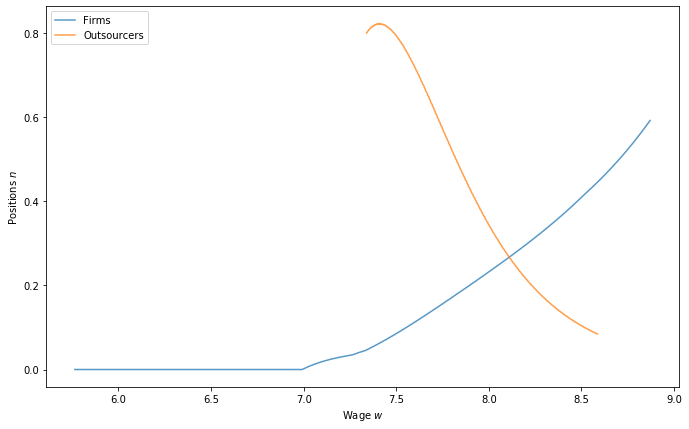

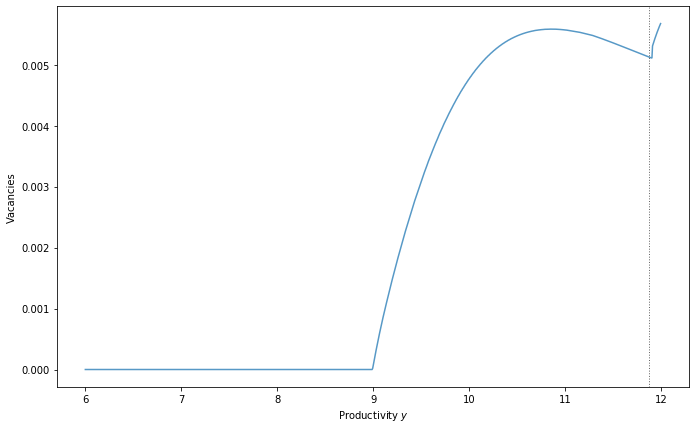

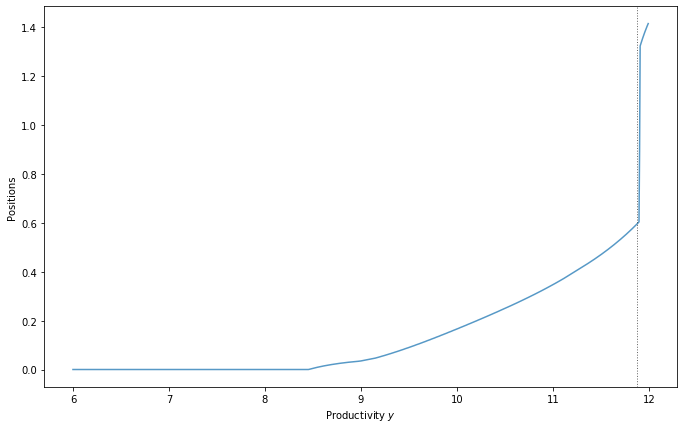

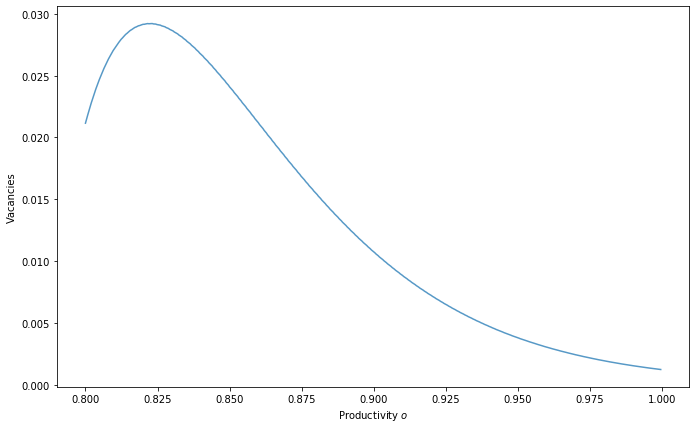

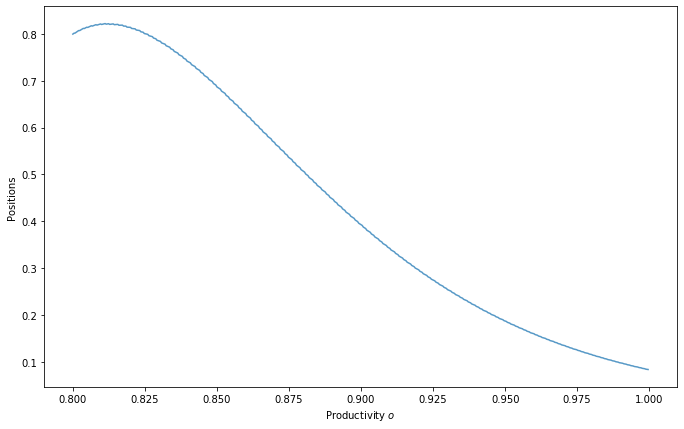

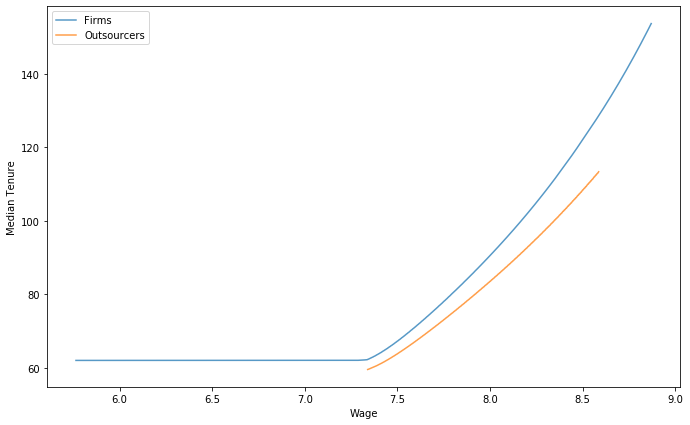

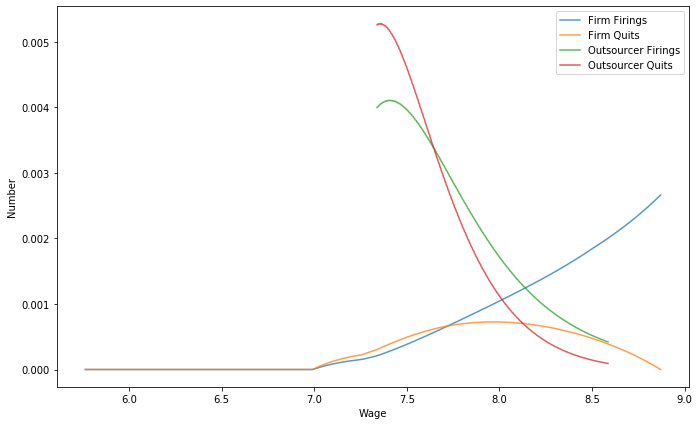

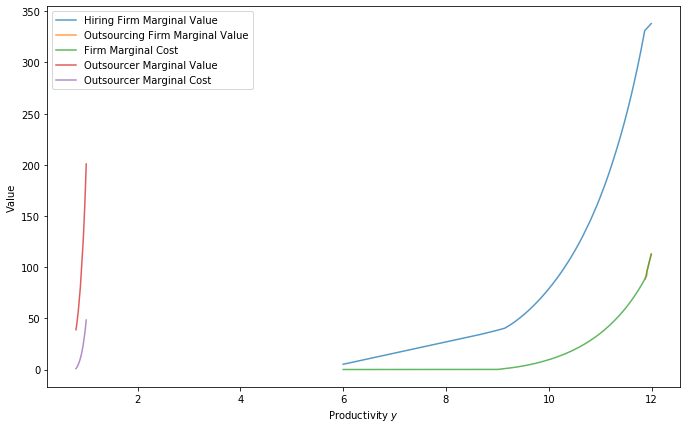

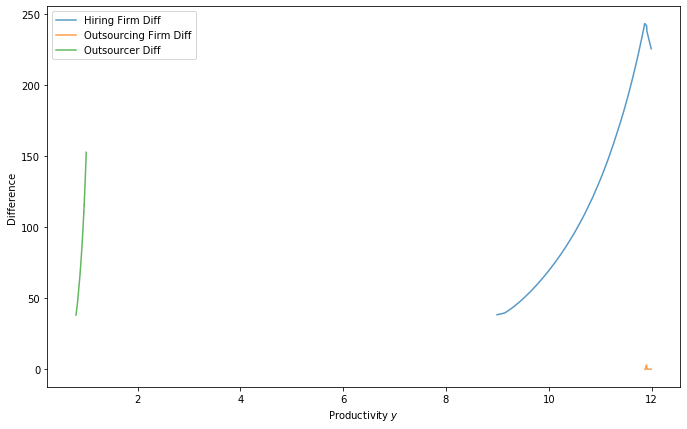

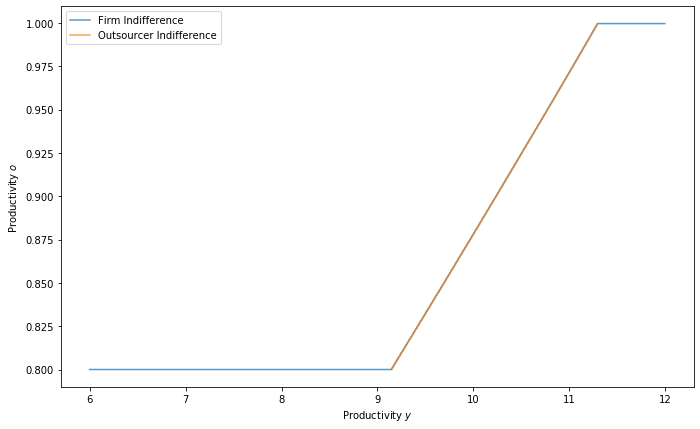

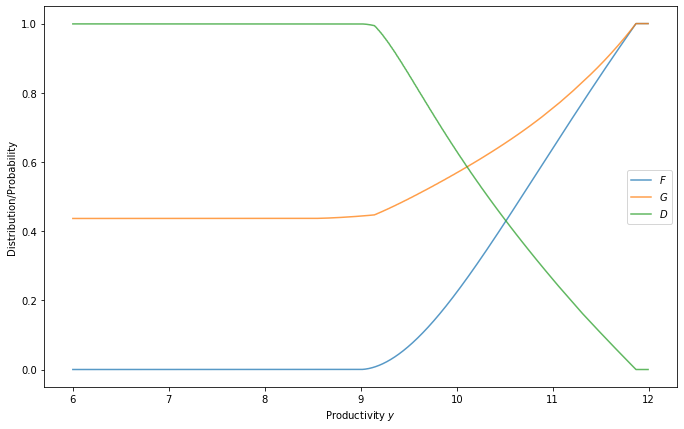

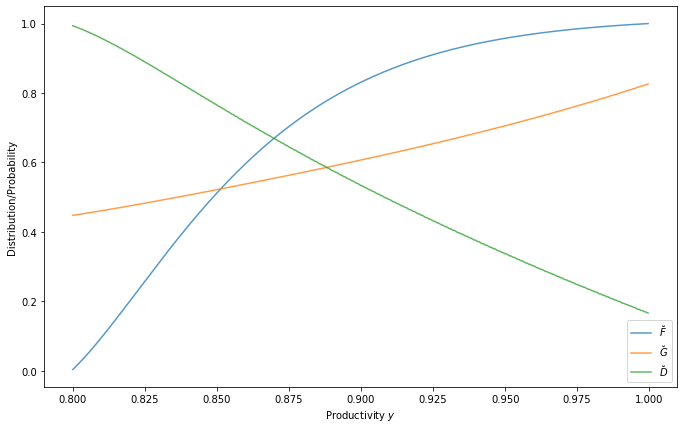

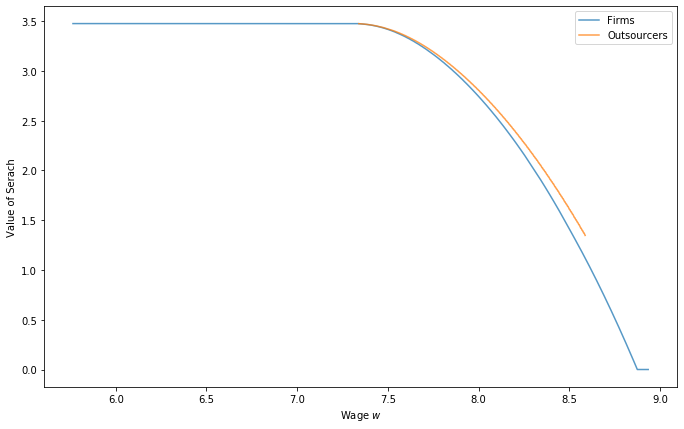

In [45]:
list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

In [9]:
x = np.array([1, 2, 5, 11], dtype=np.int32)
y = np.linspace(1, 10, 10)

np.searchsorted(y, x)
np.searchsorted?

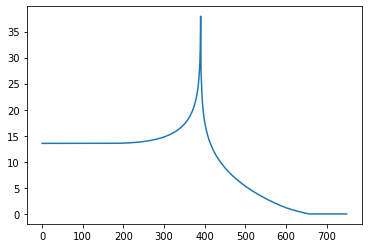

In [15]:
_, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )

plt.plot(Gamma_grid)

error is 0.0001, went through 19678 iterations
The difference in theta and theta_new is -0.0000


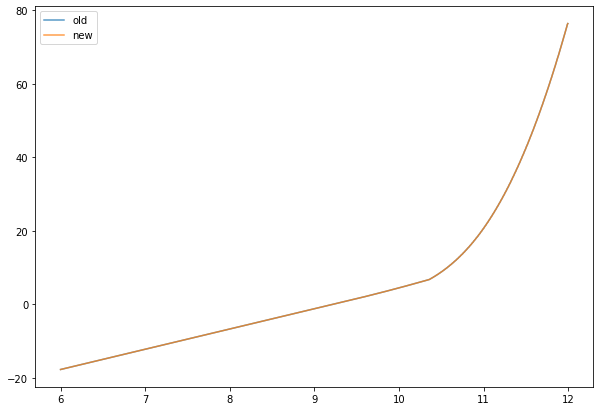

In [33]:
tol = 1e-4
max_iter = 2e4
slow = 5e-2
verbose = True

y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 

p = 13

v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size
v_o_grid = np.ones(o_grid_size) / o_grid_size
n_o_grid = np.ones(o_grid_size) / o_grid_size
# y_hat = np.intc(y_grid_size / 2)
y_hat = np.argmin(np.abs(p - y_grid))
R_grid = np.intc(np.minimum(np.arange(y_grid_size), o_grid_size))
R_o_grid = np.intc(np.minimum(np.arange(o_grid_size), y_grid_size))


iterate, QD_QS, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
# iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose
)

In [226]:
# (0.14081766803897883, 0.1435855960231627)
QD_QS(n_grid, n_o_grid, y_hat)

(0.13963359516781232, 0.14367798173932175)

In [19]:
rm, rm_o = ooj.rm, ooj.rm_o
y_hat_n = y_hat - 1

u = max(1 - np.sum(n_grid[:y_hat_n] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
v_tilde = max(np.sum(v_grid[:y_hat_n] * rm), 1e-9)
v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
s = (u + xi * (np.sum(n_grid[:y_hat_n] * rm) + np.sum(n_o_grid * rm_o)))

# Calculate theta and pi 
v_sum = v_tilde + v_o
theta = v_sum / s
theta
# 0.0967115611243406
# 0.09885978251244253
# 0.09465534417167097
ooj.q(0.09885978251244253), ooj.q(0.0967115611243406), ooj.q(0.09465534417167097)


(0.6360923467412612, 0.643118198017034, 0.6500659613748727)

In [59]:
(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

J_hire = ooj.q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
    
min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1), np.argmin(np.abs(J_out - np.maximum(J_hire, 0))), y_hat

(708, 707, 0)

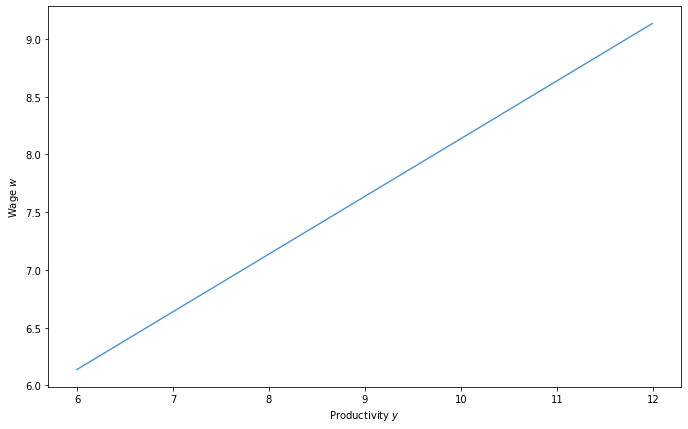

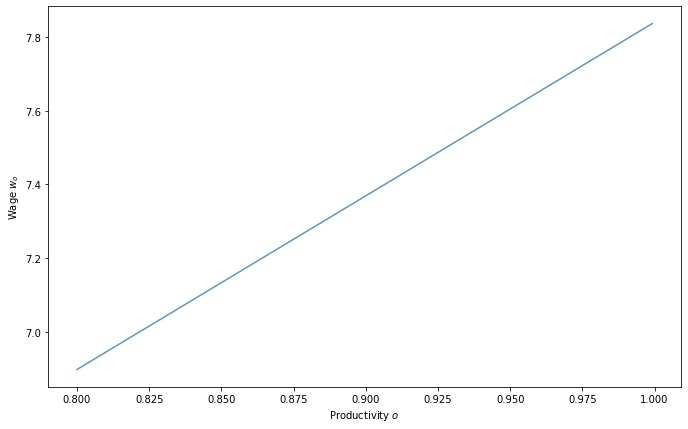

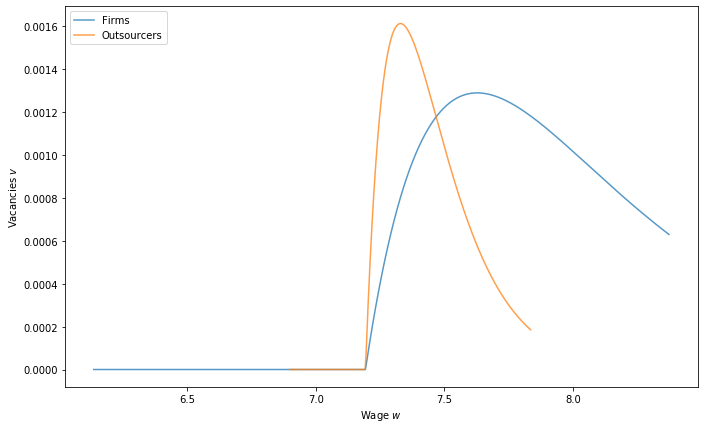

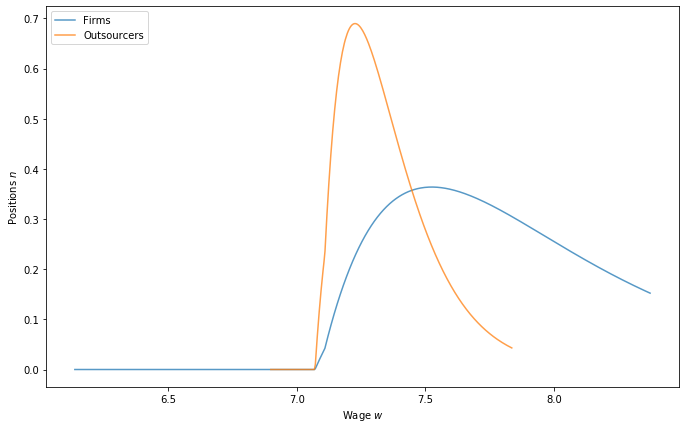

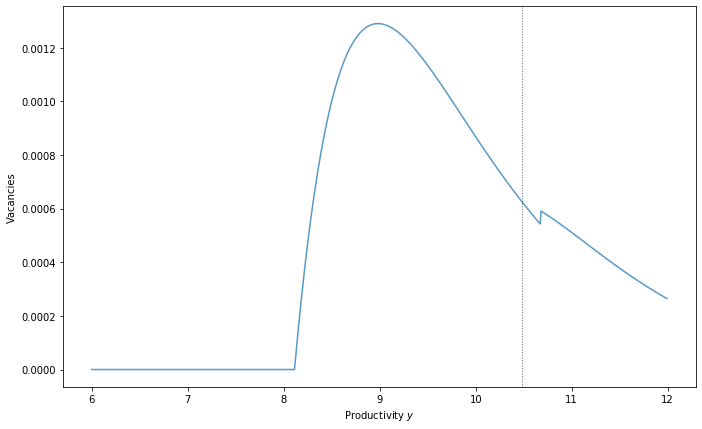

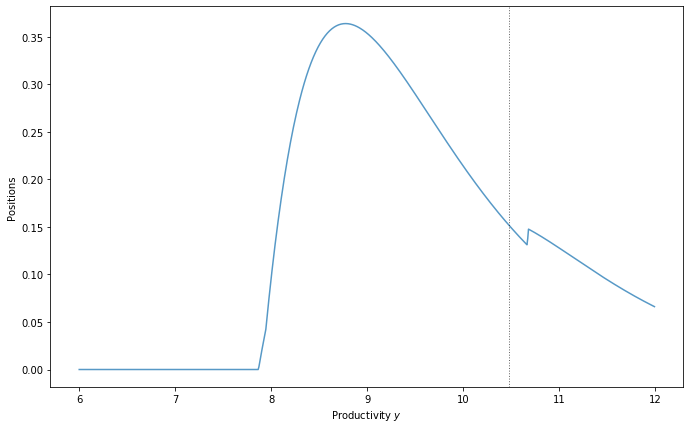

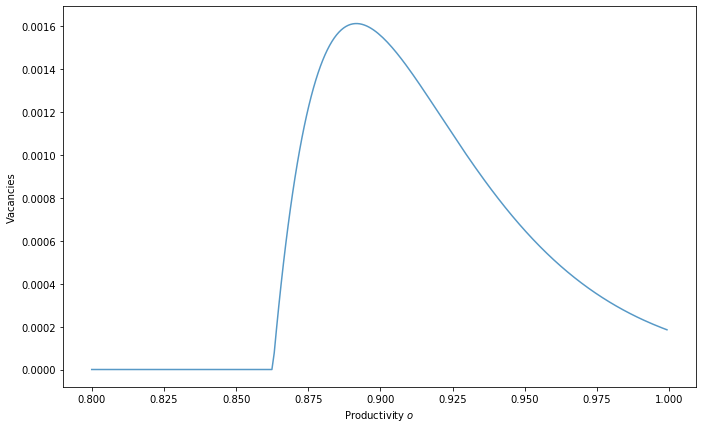

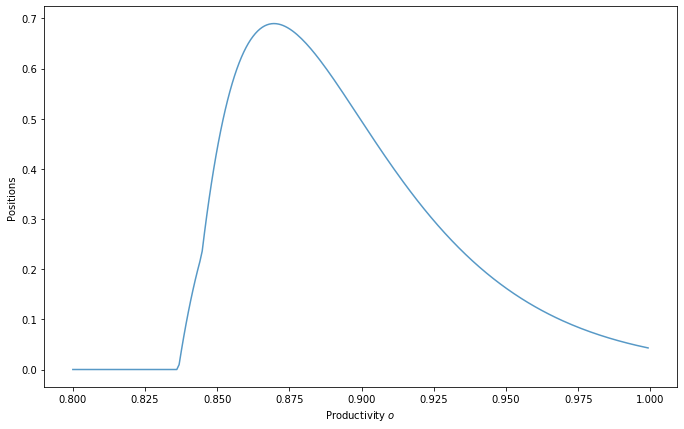

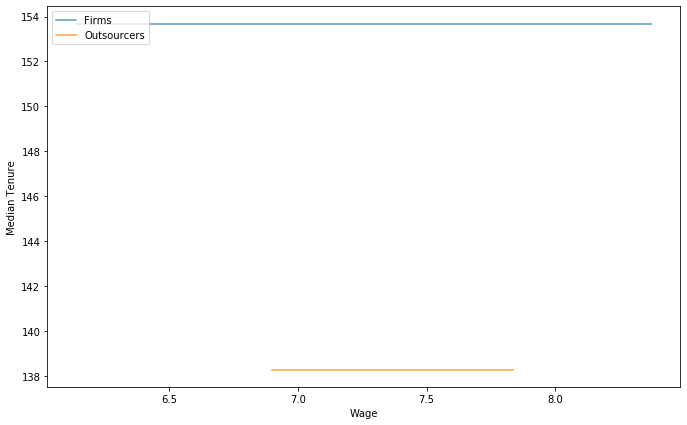

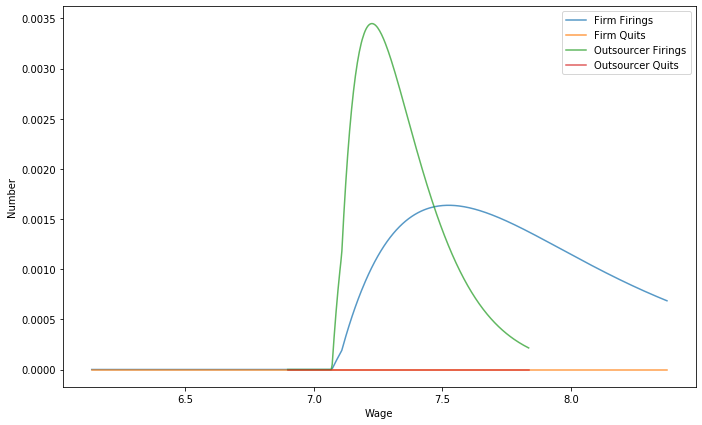

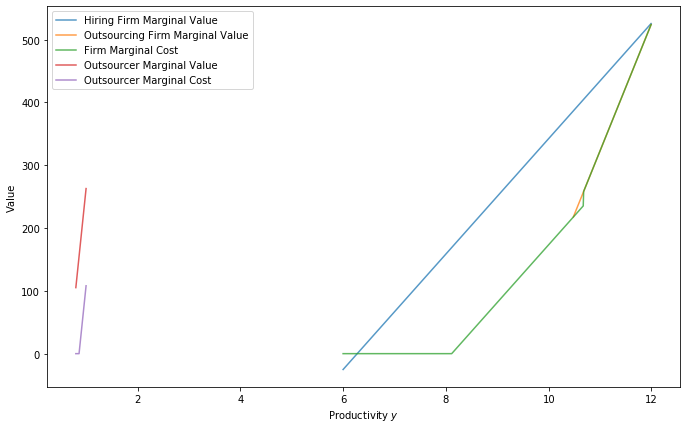

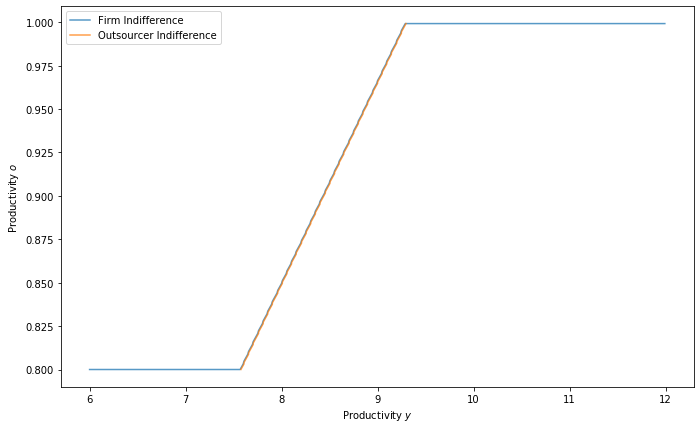

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:614: RuntimeWarning: invalid value encountered in true_divide


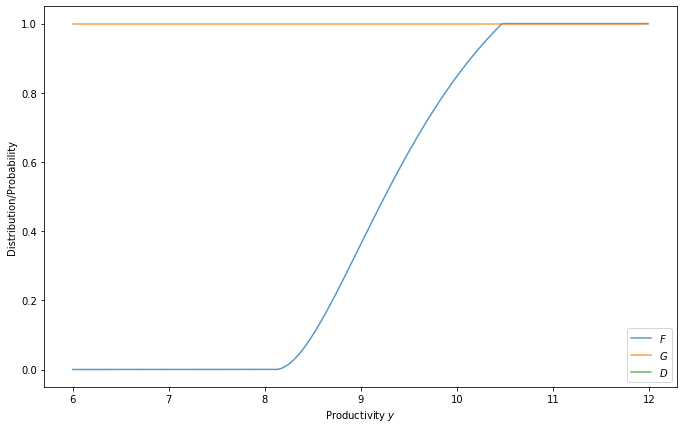

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:630: RuntimeWarning: invalid value encountered in true_divide


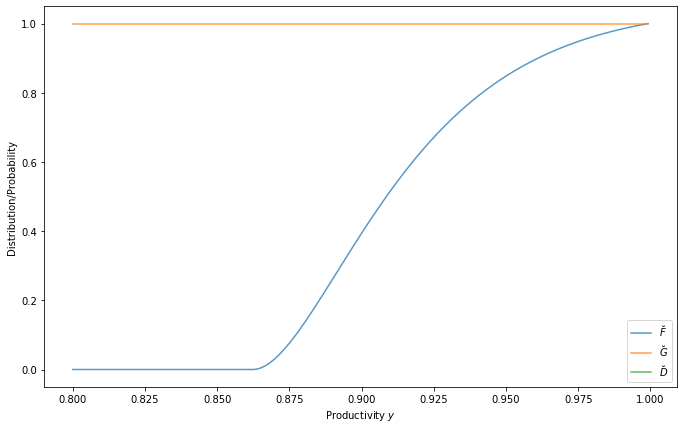

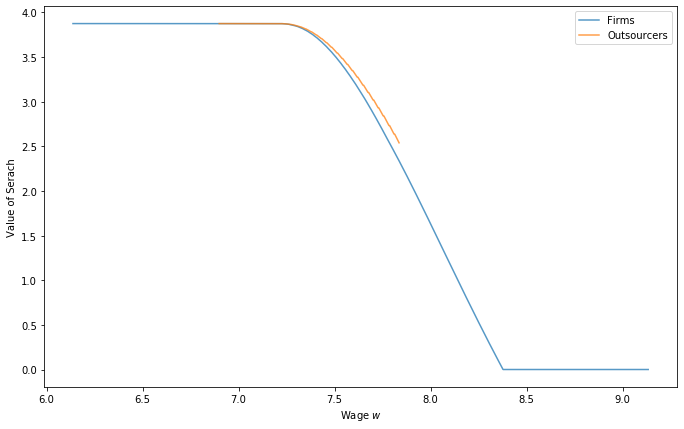

(0.16781707225120004, 0.14329024979847024)

In [229]:
iterate, QD_QS, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new = iterate(
    v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

QD_QS(n_grid_new, n_o_grid_new, y_hat_new)

error is 0.0119, went through 10000 iterations
The difference in theta and theta_new is -0.0600


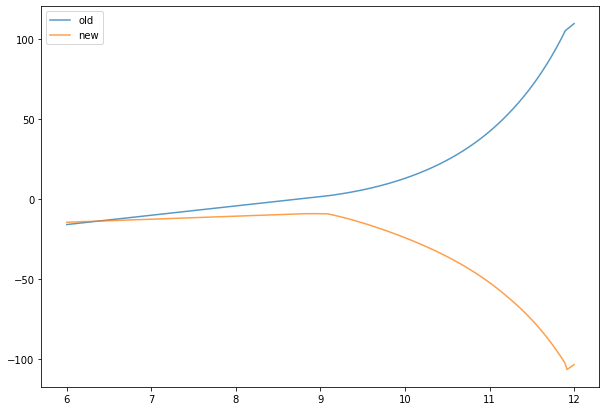

The indifferent firm is y_hat = 11.92$. Price of outsourcing is 11.37.
Unemployment is 1.66. According to LoM, should be 4.44
Workers match with probability 9.85. Firms/Outsourcers match with probability 40.61
Total vacancies searching for workers are 0.0279. Theta is 0.2425
31 percent of vacancies searching for workers are from outsourcers, 16 percent of postions outsourced
The ue rate is 0.10, the ee rate is 0.01,  and 15.963256 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.949235 at position 7871 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 1.565387 at position 52


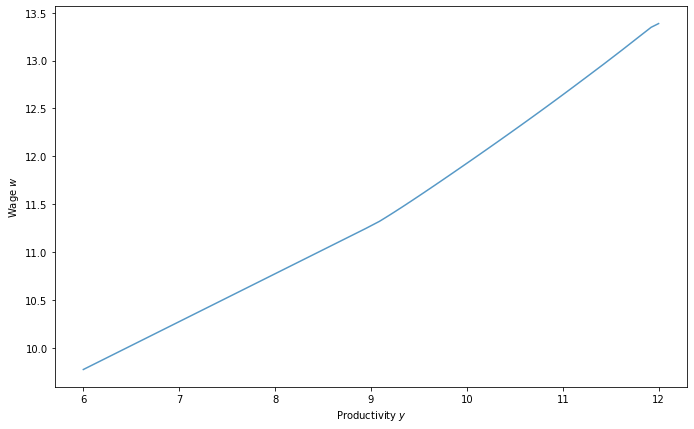

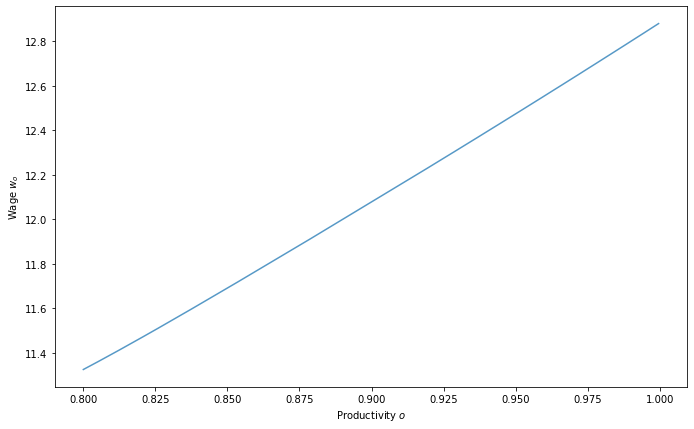

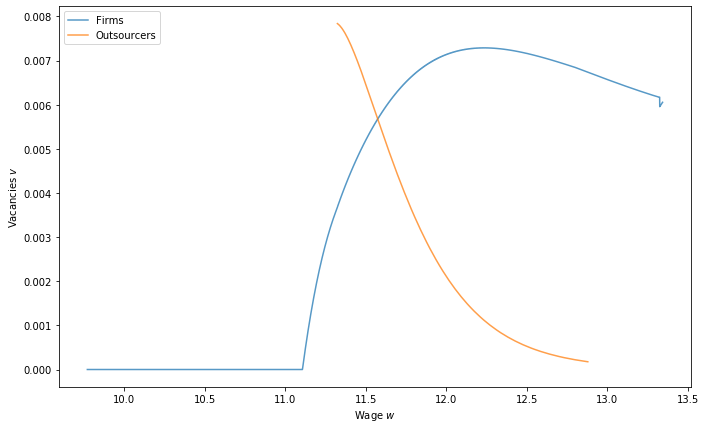

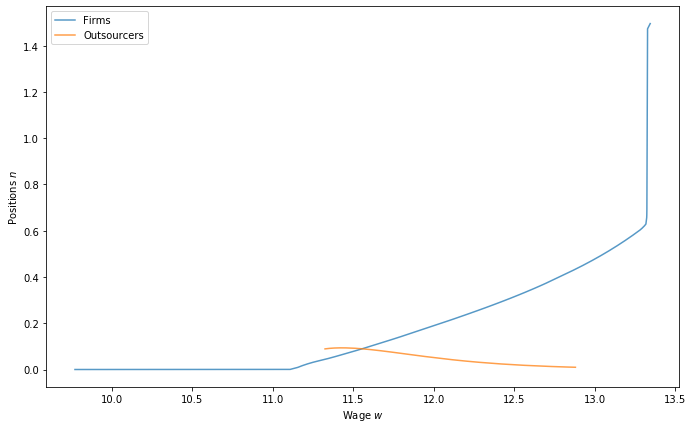

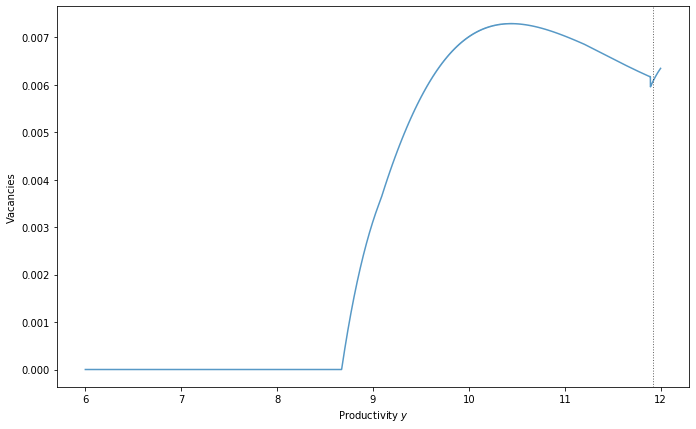

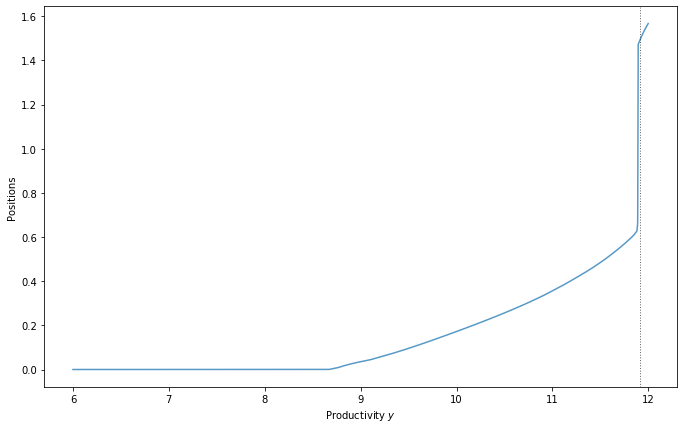

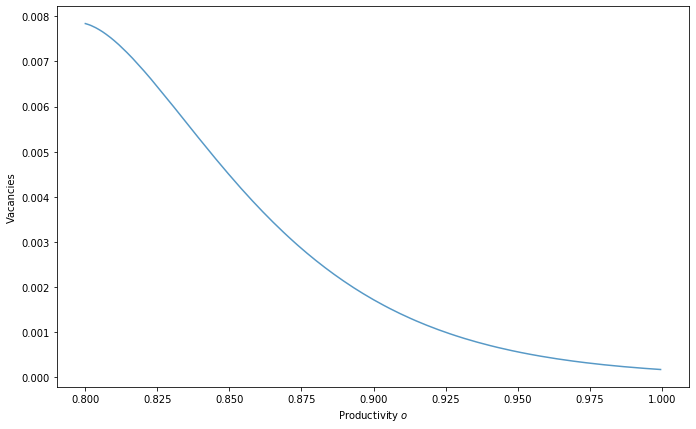

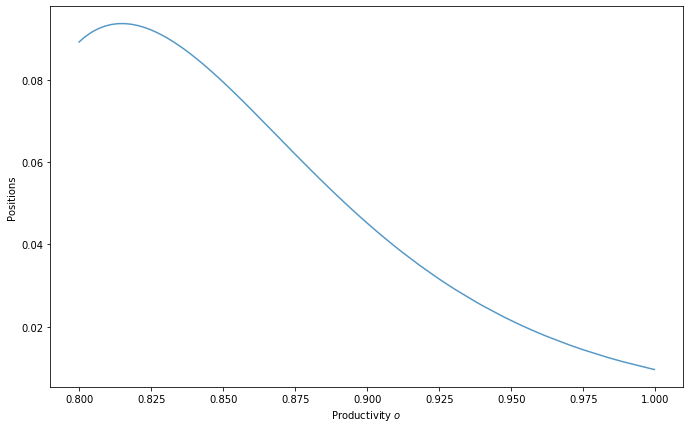

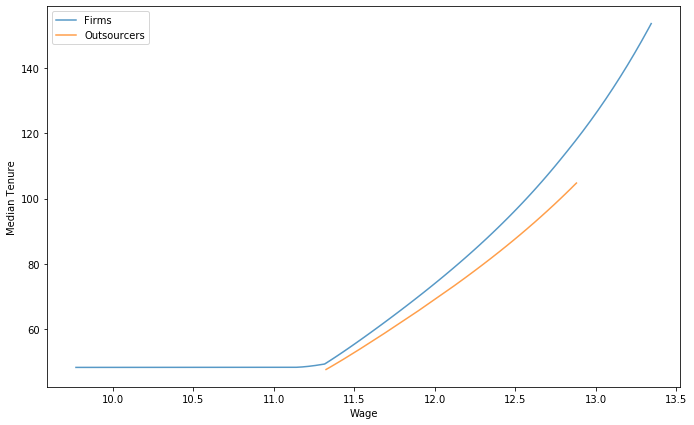

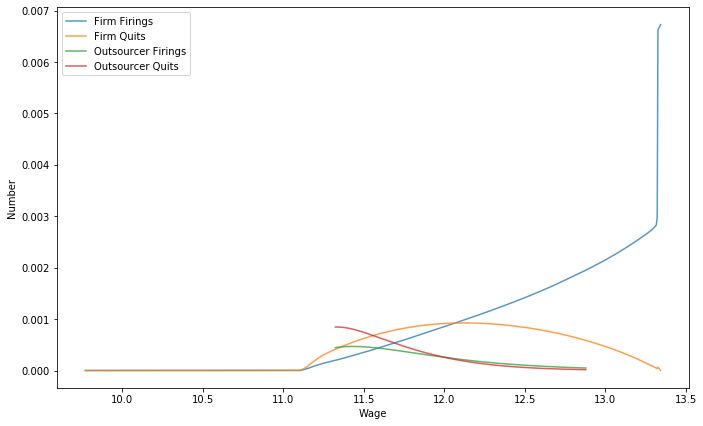

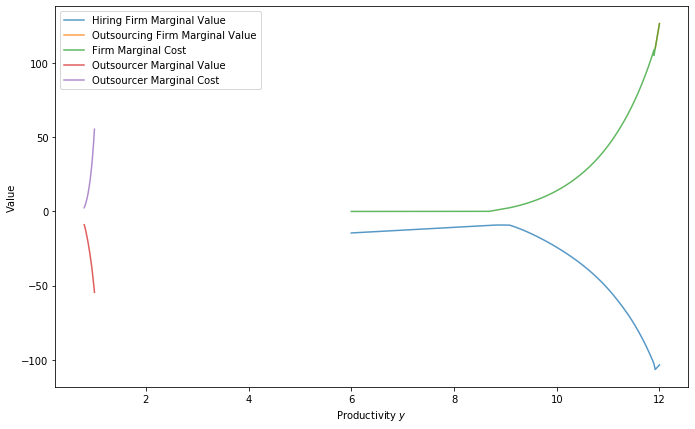

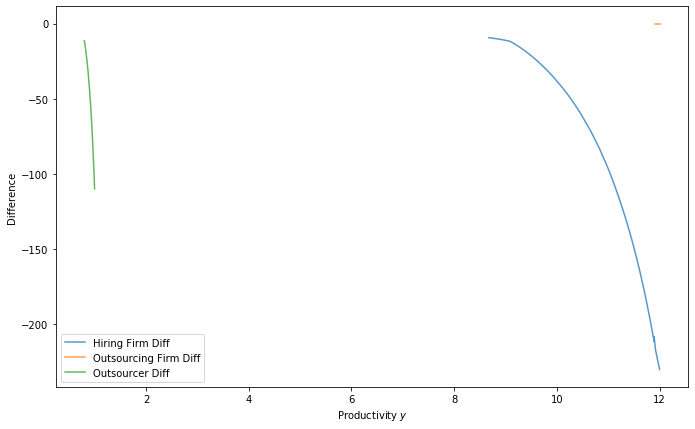

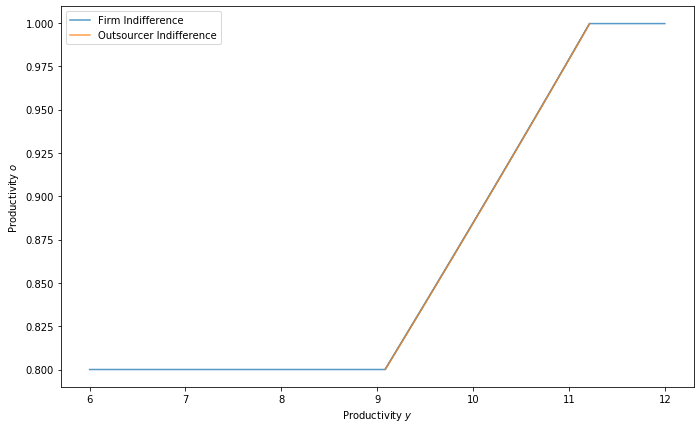

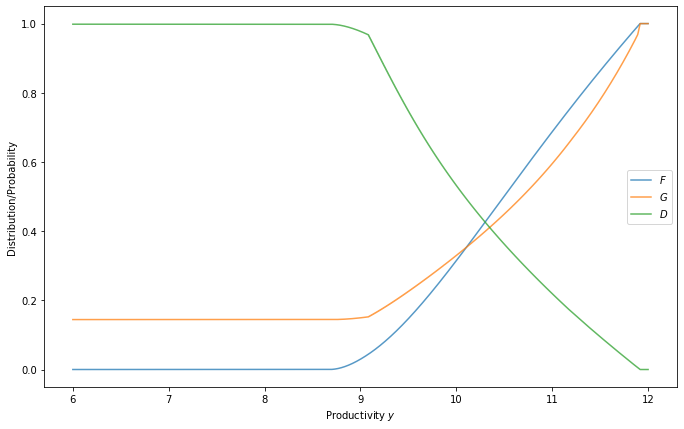

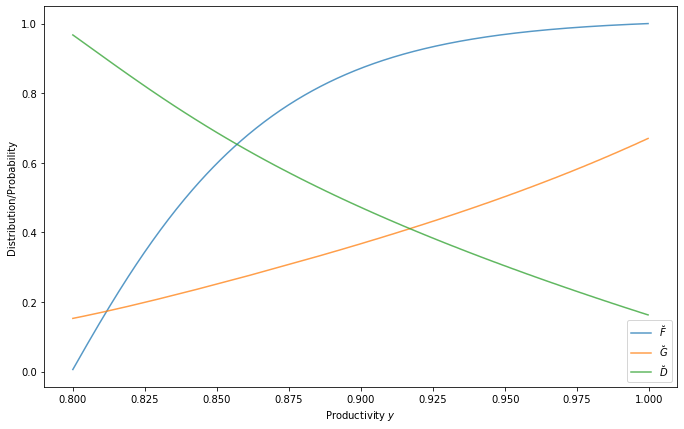

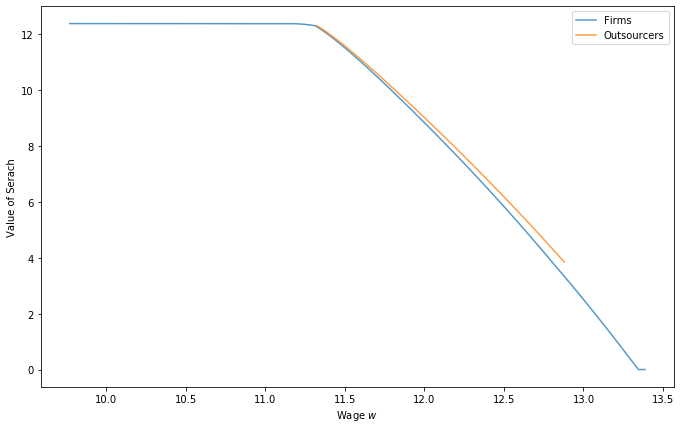

In [24]:
tol = 1e-4
max_iter = 1e4
slow = 1e-2
verbose = True

v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose
)

list_facts(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

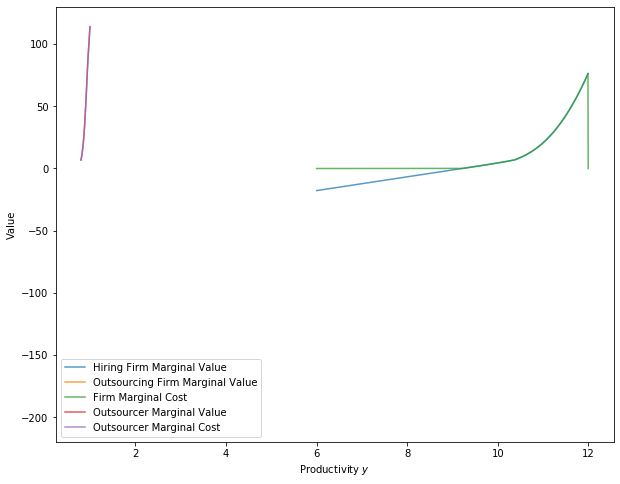

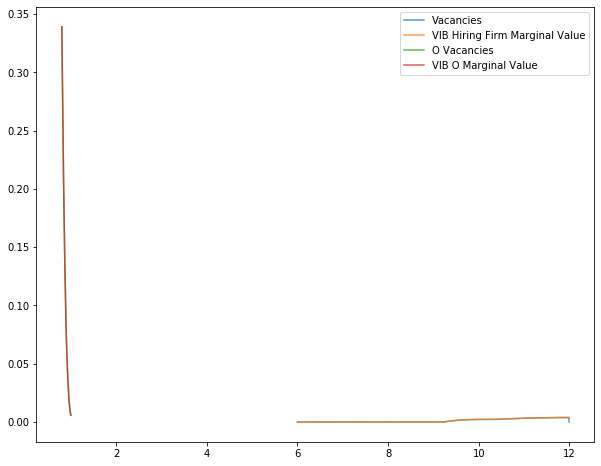

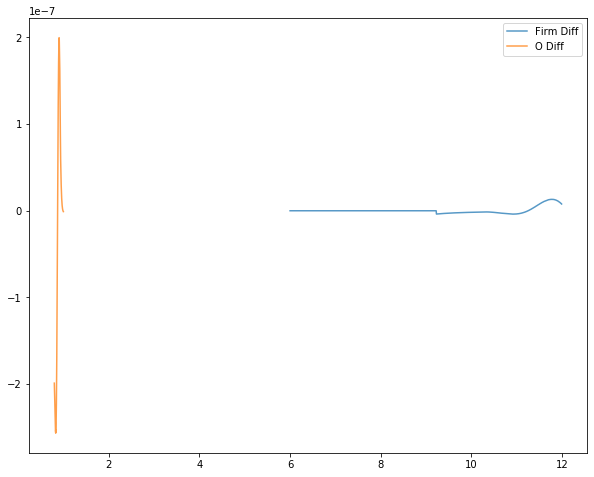

In [37]:
iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# (theta, G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

q = ooj.q
y_grid, o_grid = ooj.y_grid, ooj.o_grid

J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
mc = c(v_grid)    

O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
mc_o = c_o(v_o_grid) 

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
ax.set(xlabel="Productivity $y$", ylabel="Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies")
ax.plot(y_grid, c_inv(J_hire), alpha=0.75, label="VIB Hiring Firm Marginal Value")
ax.plot(o_grid, v_o_grid, alpha=0.75, label="O Vacancies")
ax.plot(o_grid, c_o_inv(O), alpha=0.75, label="VIB O Marginal Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid[:y_hat], v_grid[:y_hat] - c_inv(J_hire)[:y_hat], alpha=0.75, label="Firm Diff")
ax.plot(o_grid, v_o_grid - c_o_inv(O), alpha=0.75, label="O Diff")
ax.legend(loc="best")

plt.show()

In [64]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize, int32, float64
from IPython.core.debugger import set_trace

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):           
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate pi 
        v_sum = v_tilde + v_o
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
        f_grid = v_grid / v_tilde
        f_grid[y_hat:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_grid)
        n_temp[y_hat:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):
        
        (G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)
        
        v_grid_new = np.empty(y_grid_size)
        n_grid_new = np.empty(y_grid_size)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
#         y_hat_new = min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1)
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = max(y_diff, y_zero)
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new[:y_hat] = c_inv(J_hire)[:y_hat]
        
        # Outsourcing firms (above y_hat)
        v_grid_new[y_hat:] = c_inv(J_out)[y_hat:]
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_temp = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        n_grid_new[:y_hat] = n_temp[:y_hat]
        
        # Outsourcing firms
        n_grid_new[y_hat:] = (1 - delta_hat) * n_grid[y_hat:] + v_grid_new[y_hat:]
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
                
        # Use these to find new indecision rules
#         R_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U[i] - W_o_min_U)) for i in np.arange(y_grid_size)]
#         )
#         R_o_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U - W_o_min_U[i])) for i in np.arange(o_grid_size)]
#         )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        # Update theta
        u = max(1 - np.sum(n_grid_new[:y_hat] * rm) - np.sum(n_o_grid_new * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid_new[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid_new * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)))
        theta_new = (v_tilde + v_o) / (u + xi * (1 - u))
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
                y_hat_new, R_grid_new, R_o_grid_new, theta_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS(n_grid, n_o_grid, y_hat):
        QD = np.sum(n_grid[y_hat:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        return QD, QS
    
    return iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and theta
    while i < max_iter and err > tol:
        (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
         y_hat_new, R_grid_new, R_o_grid_new, theta_new) = iterate(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
        )
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v, err_v_o, err_n, err_n_o)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
        theta = slow * theta_new + (1 - slow) * theta
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1/5 if greater/less (depend on size)
#         y_pos = 1 * (y_hat_new > y_hat) + 4 * (y_hat_new - y_hat > 50)
#         y_neg = 1 * (y_hat_new < y_hat) + 4 * (y_hat_new - y_hat < -50)
#         y_hat = y_hat + y_pos - y_neg
        
#         R_pos = 1 * (R_grid_new > R_grid) + 4 * (R_grid_new - R_grid > 50)
#         R_neg = 1 * (R_grid_new < R_grid) + 4 * (R_grid_new - R_grid < -50)
#         R_grid = R_grid + R_pos - R_neg
        
#         R_o_pos = 1 * (R_o_grid_new > R_o_grid) + 4 * (R_o_grid_new - R_o_grid > 50)
#         R_o_neg = 1 * (R_o_grid_new < R_o_grid) + 4 * (R_o_grid_new - R_o_grid < -50)
#         R_o_grid = R_o_grid + R_o_pos - R_o_neg
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
        y_hat = y_hat + 1 * (y_hat_new > y_hat) - 1 * (y_hat_new < y_hat)
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)

    if verbose:
        (G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)
        (G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"y_hat is {y_hat:.4f}, y_hat_new is {y_hat_new:.4f}")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new")
        ax.legend()
        plt.show()       
        
    return (
        v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat, R_grid_new, R_o_grid_new, theta_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    xi, rm, rm_o = ooj.xi, ooj.rm, ooj.rm_o
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        v_tot = np.sum(v_grid_new[:y_hat] * rm) + np.sum(v_o_grid_new * rm_o)
        u = 1 - np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)
        theta = v_tot / (u + xi * (1 - u))
        
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta = solve_given_p(
            ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol_i, max_iter_i, slow_i
        )
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Excess Demand for price {p} is {QD - QS:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2
        
#         # Initial guesses (reset initially)
#         if j <= 5:
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#             y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        v_tot = np.sum(v_grid_new[:y_hat] * rm) + np.sum(v_o_grid_new * rm_o)
        u = 1 - np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)
        theta = v_tot / (u + xi * (1 - u))
              
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol_i, max_iter_i, slow_i
)
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        ed = QD - QS
        err = np.abs(ed)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ed > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_grid[y_hat]}"
            )
            
        j += 1
        
#     # Run one more loop with 10 times the iterations, 1/100 the tolerance
#     if verbose:
#         print(
#             f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
#             f"y_hat is {y_grid[y_hat]}\n One more loop..."
#         )
            
#     v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
#     ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid,
#         tol_i / 100, max_iter_i * 10, slow_i
# )
#     QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
#     ed = QD - QS
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ed:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ed:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], v_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], n_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies $v$")
#     ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
#     ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], median_tenure[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], firings[:y_hat], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_hat], quits[:y_hat], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    J_out = (y_grid - p) / (r + delta_hat)
    mc = c(v_grid)    
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_hat:], J_out_diff[y_hat:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v_tilde = np.sum(v_grid[:y_hat] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\breve{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\breve{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\breve{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):
    
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
    )
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    print(f"The indifferent firm is y_hat = {y_grid[y_hat]:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o)
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_hat] * D_grid[:y_hat] * rm) / np.sum(n_grid[:y_hat] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.2f}, the ee rate is {ee:.2f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss_tilde = v_grid[:y_hat] * q(theta) * G_grid[:y_hat] / delta
    n_tilde = n_grid[:y_hat]
    if y_hat > min(y_grid):
        err_tilde = max(np.abs(n_ss_tilde - n_tilde))
        err_tilde_at = np.argmax(np.abs(n_ss_tilde - n_tilde))
    else:
        err_tilde = 0
        err_tilde_at = 0
    
    n_ss_hat = v_grid[y_hat:] / delta_hat
    n_hat = n_grid[y_hat:]
    if y_hat < max(y_grid):
        err_hat = max(np.abs(n_ss_hat - n_hat))
        err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat))
    else:
        err_hat = 0
        err_hat_at = 0
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / delta_o
    n_o = v_o_grid
    err_o = max(np.abs(n_o_ss - n_o))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms large error = {err_tilde:.6f} at position {err_tilde_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )                       

Excess Demand for price 6 is 1631.1999; QS is 0.0044; QD is 1631.2042
Excess Demand for price 12 is -0.2770; QS is 0.2770; QD is 0.0000
Excess Demand at iter 0 is 43.6082; price is 9.0000; QS is 0.0170; QD is 43.6251 y_hat is 9.204
Excess Demand at iter 5 is 0.0697; price is 11.3438; QS is 0.1366; QD is 0.2063 y_hat is 11.850000000000001
Failed to Converge. Excess Demand is -0.0094; price is 11.3848;  QS is 0.1419; QD is 0.1325
The indifferent firm is y_hat = 11.90$. Price of outsourcing is 11.38.
Unemployment is 4.65. According to LoM, should be 4.84
Workers match with probability 9.02. Firms/Outsourcers match with probability 44.37
Total vacancies searching for workers are 0.0299. Theta is 0.2032
32 percent of vacancies searching for workers are from outsourcers, 17 percent of postions outsourced
The ue rate is 0.09, the ee rate is 0.01,  and 35.935629 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.393775 at position

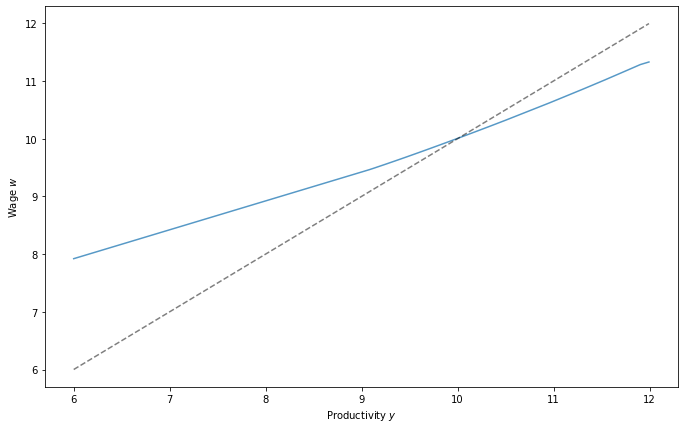

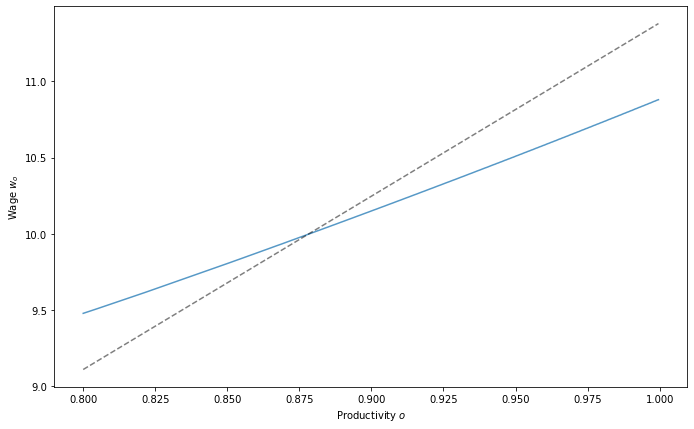

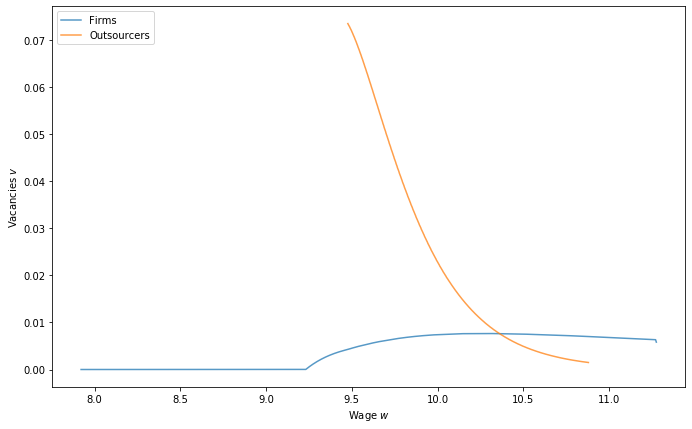

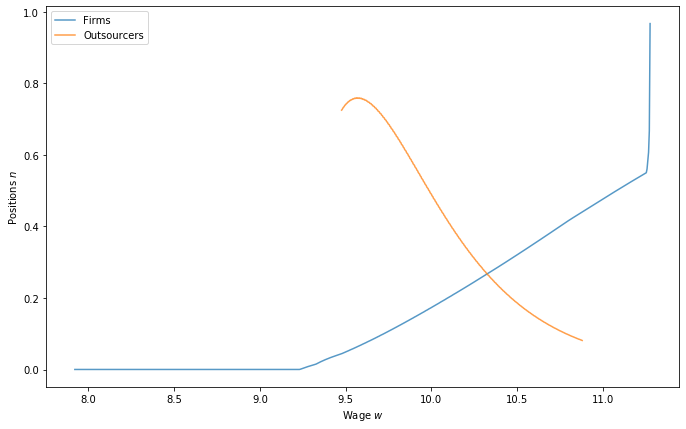

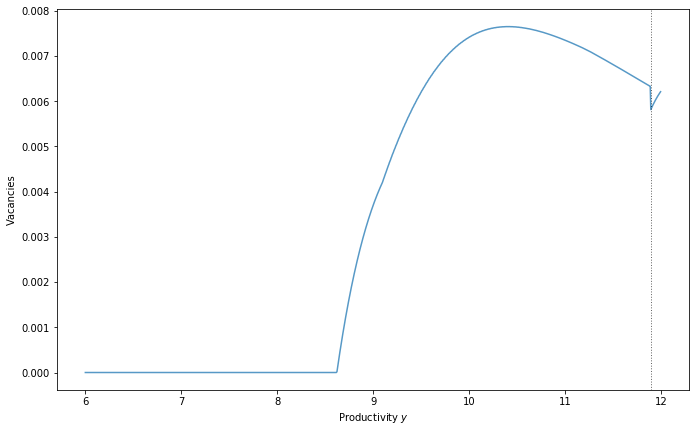

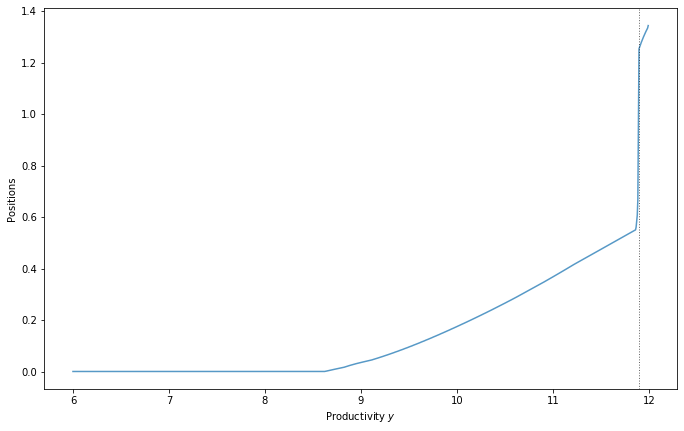

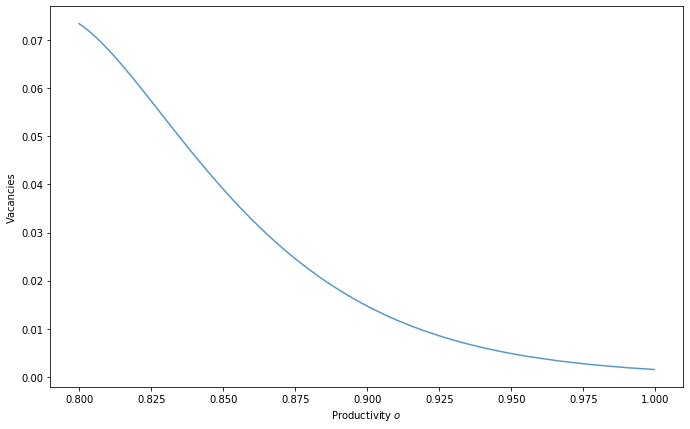

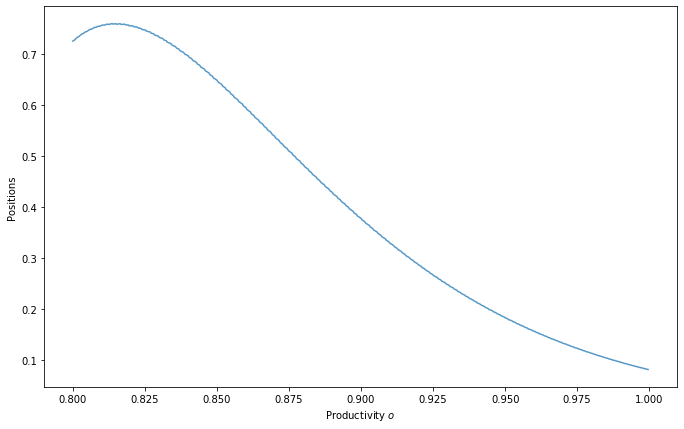

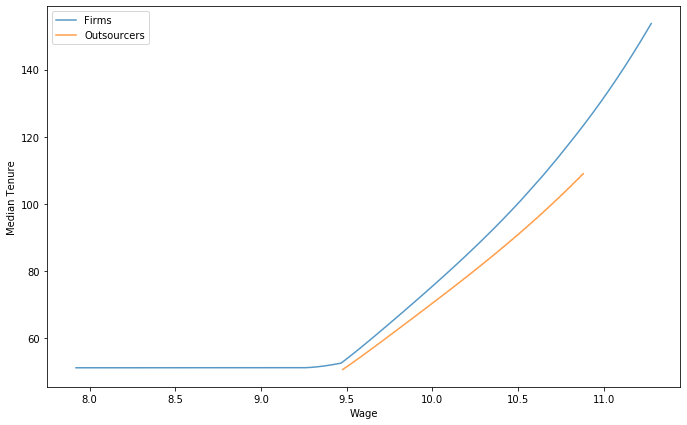

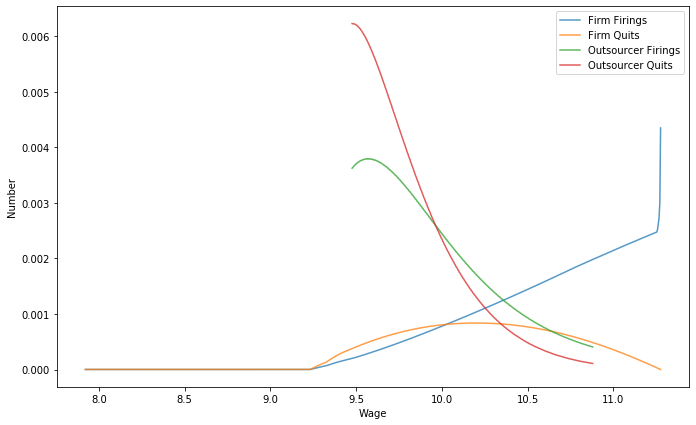

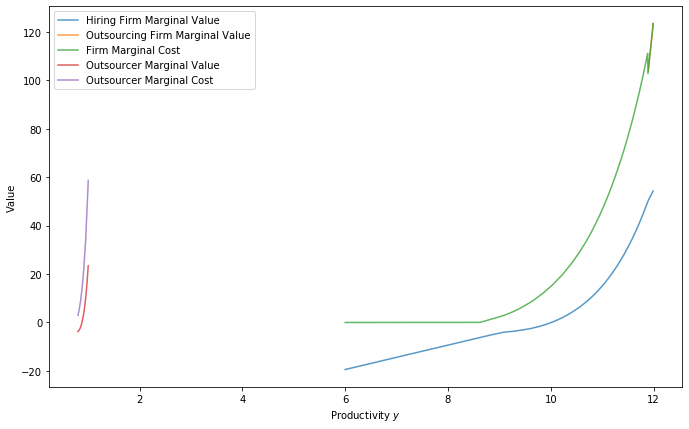

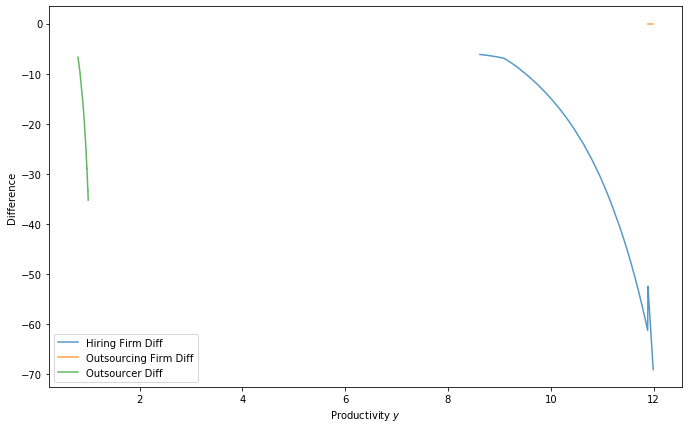

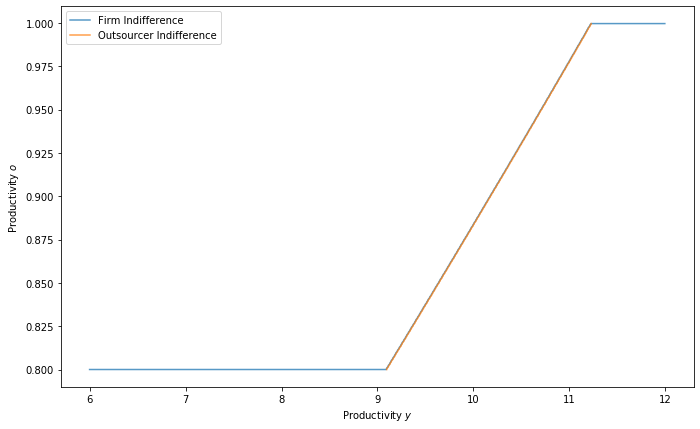

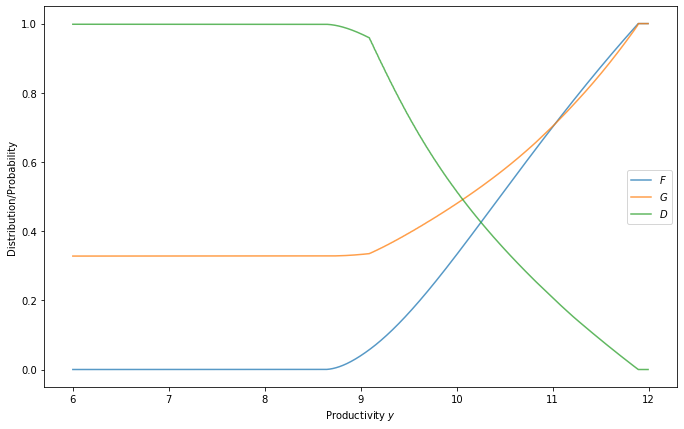

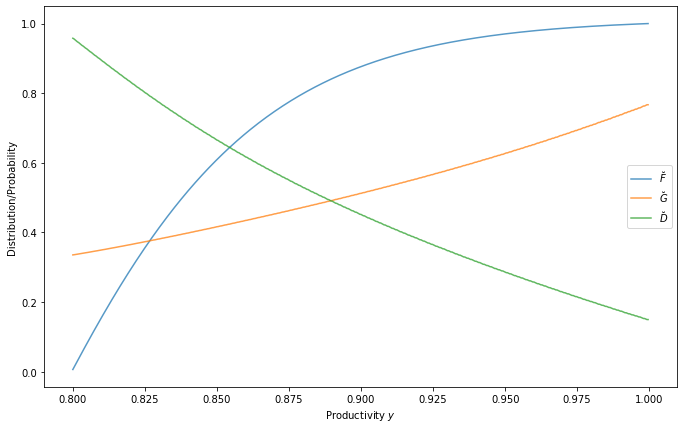

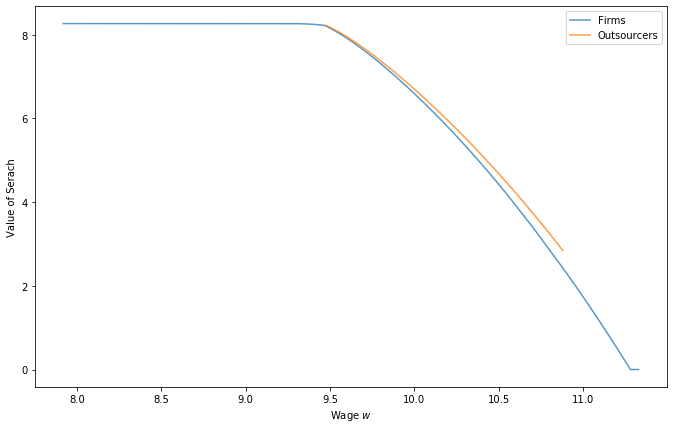

In [65]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.8
o_max = 1.0
b = y_min * .4 
y_grid_size = 1000
# y_grid_size = 8000
o_grid_size = 500
gamma = 2
gamma_o = 2
k_grid = np.logspace(1, 4, y_grid_size, endpoint = False)
k_o_grid = np.logspace(1, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 6
p_high = 12
tol = 1e-4
max_iter = 10
tol_i = 1e-4
max_iter_i = 5e4
slow_i = 1e-2
print_skip = 5
verbose = True

save = False

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p = find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p,
             save=save)

error is 0.0331, went through 10000 iterations
y_hat is 982.0000, y_hat_new is 981.0000
The difference in theta and theta_new is 0.0210


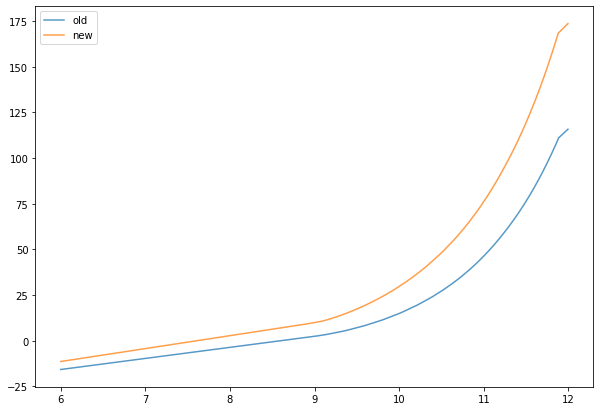

The indifferent firm is y_hat = 11.89$. Price of outsourcing is 11.38.
Unemployment is 5.41. According to LoM, should be 5.40
Workers match with probability 8.04. Firms/Outsourcers match with probability 49.77
Total vacancies searching for workers are 0.0231. Theta is 0.1615
30 percent of vacancies searching for workers are from outsourcers, 17 percent of postions outsourced
The ue rate is 0.08, the ee rate is 0.01,  and 37.600104 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.171625 at position 725 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 3.216710 at position 37


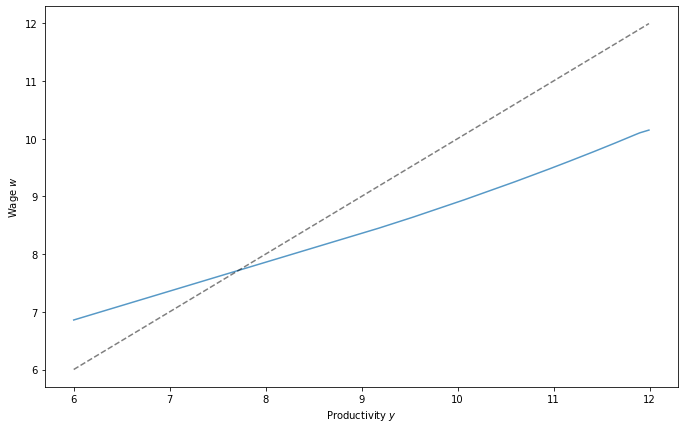

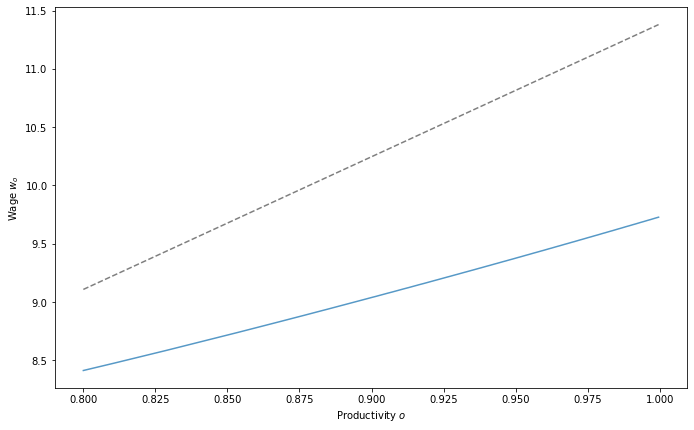

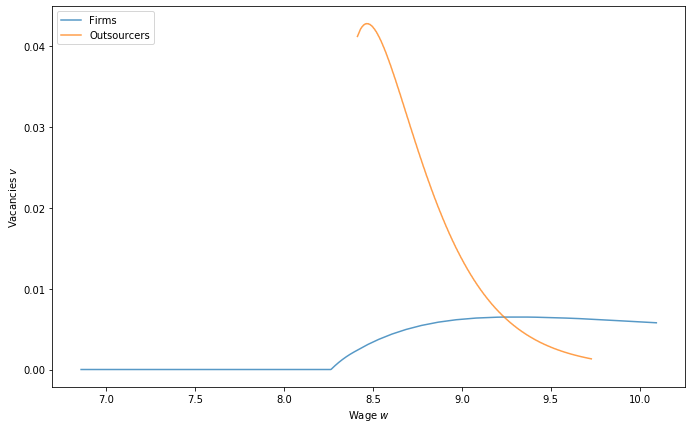

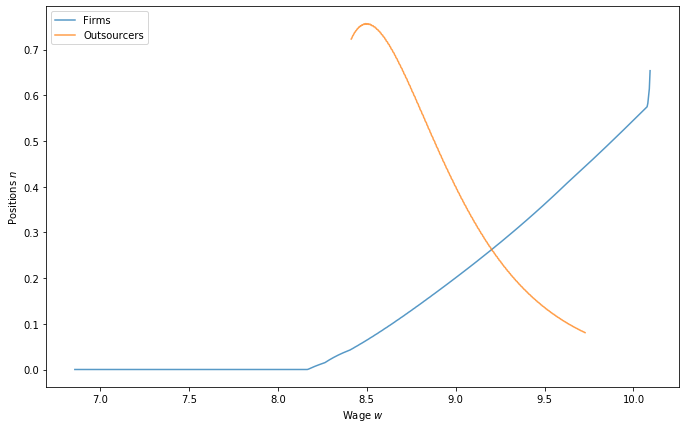

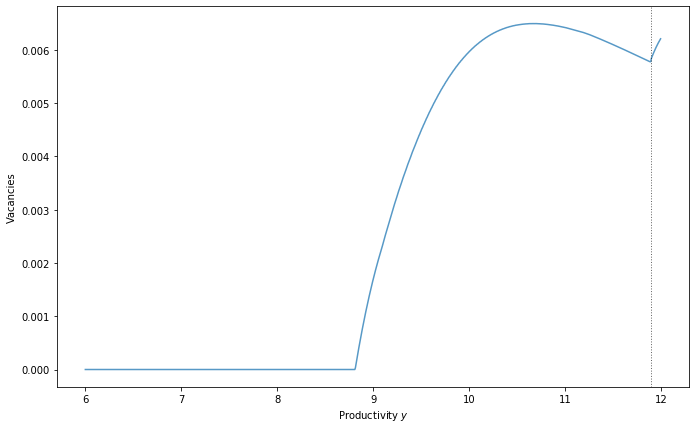

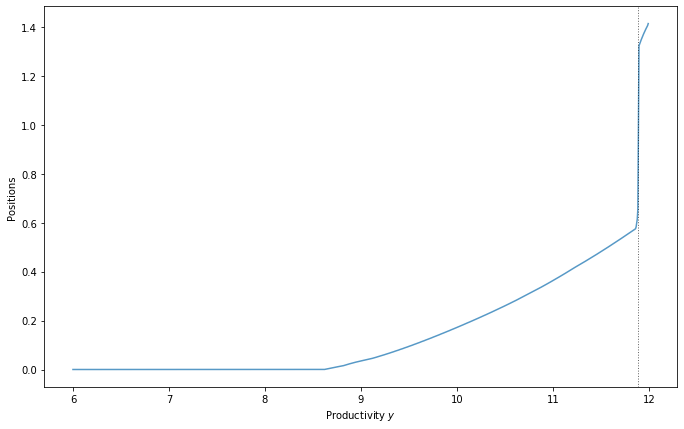

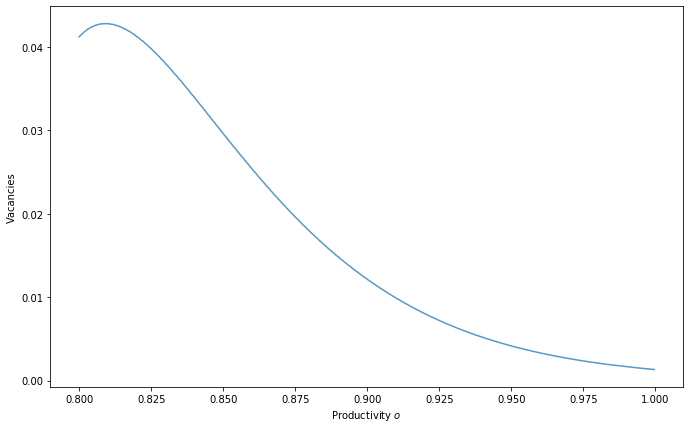

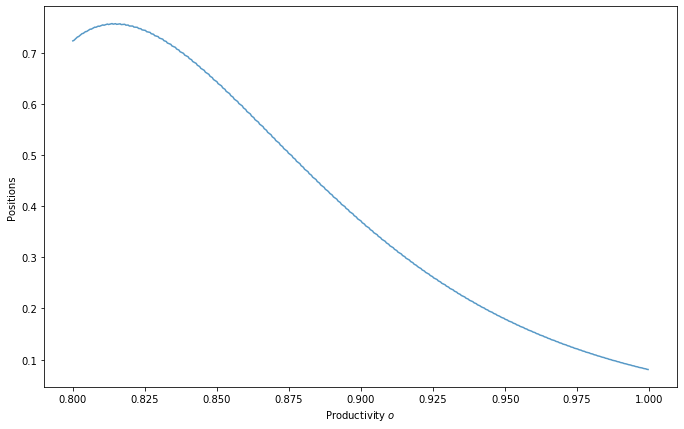

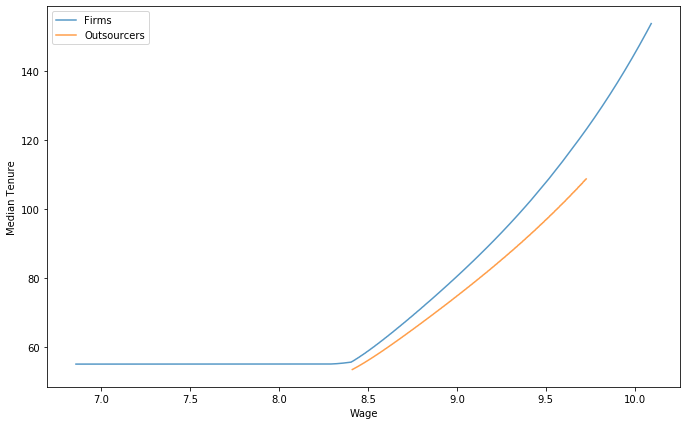

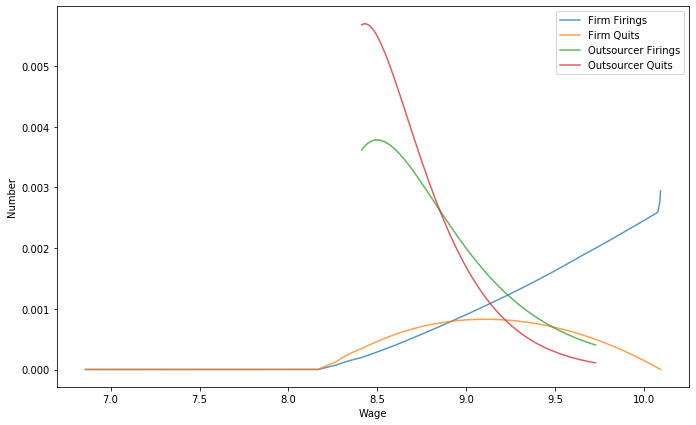

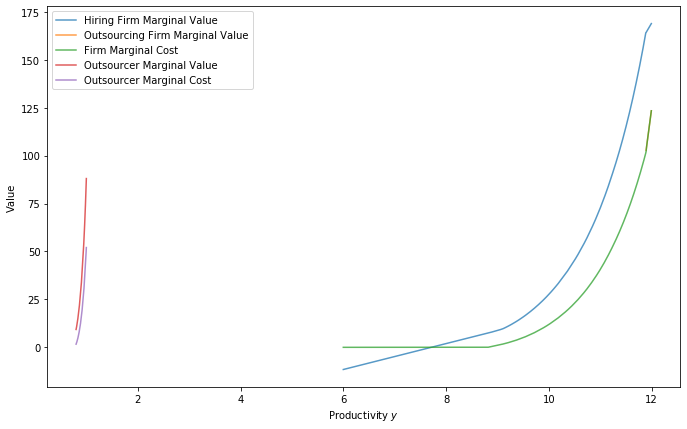

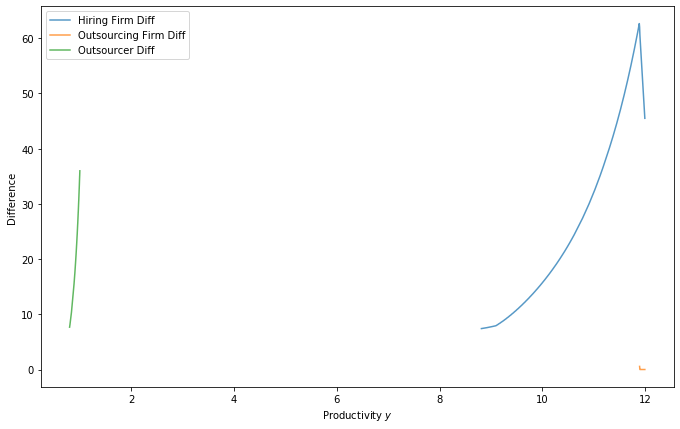

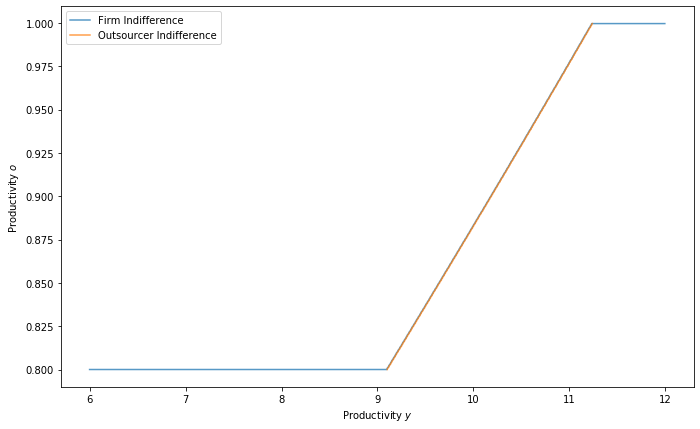

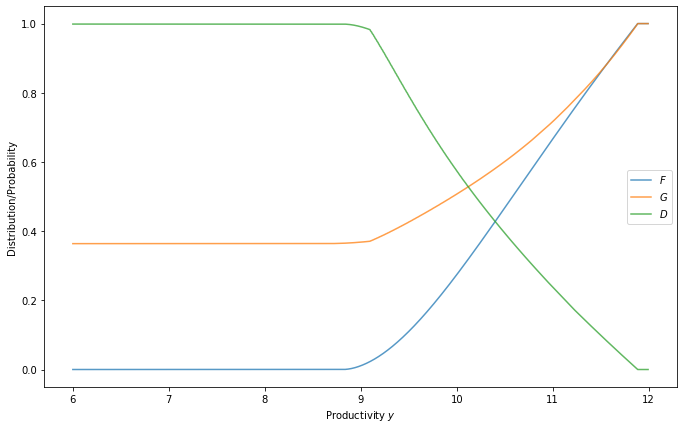

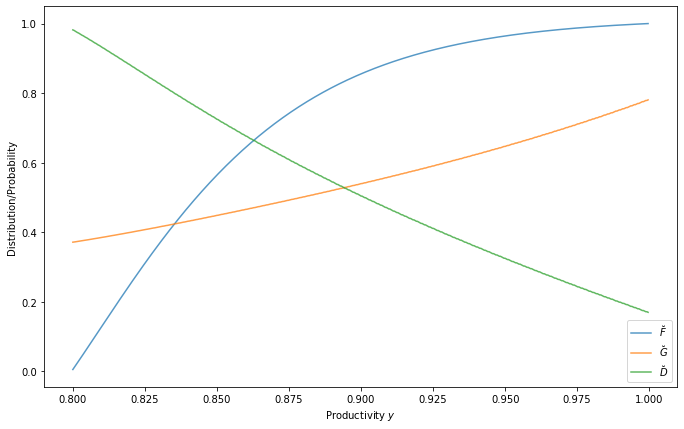

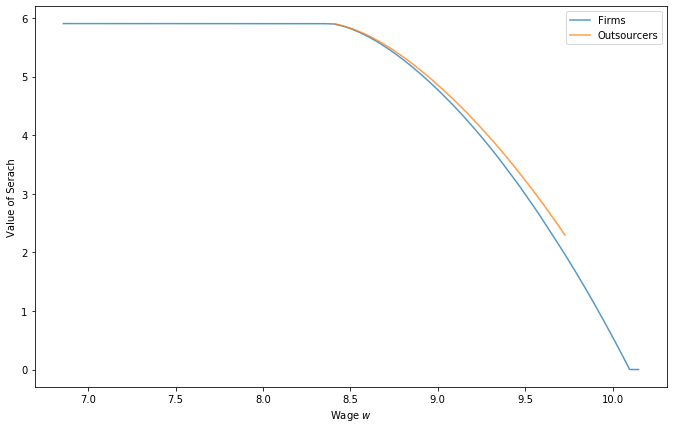

In [66]:
tol = 1e-4
max_iter = 1e4
slow = 1e-2
verbose = True

v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol, max_iter, slow, verbose
)

list_facts(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

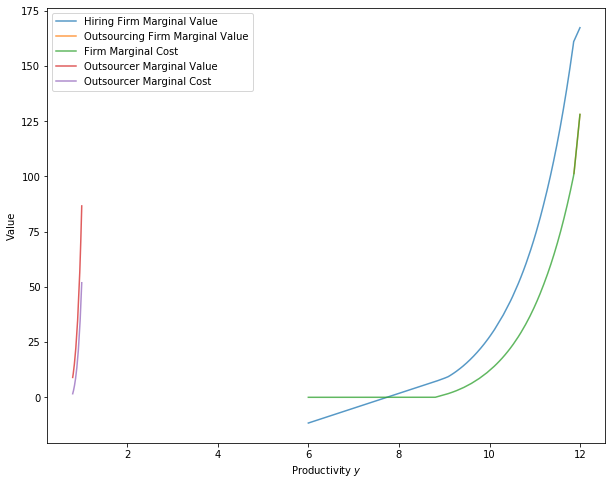

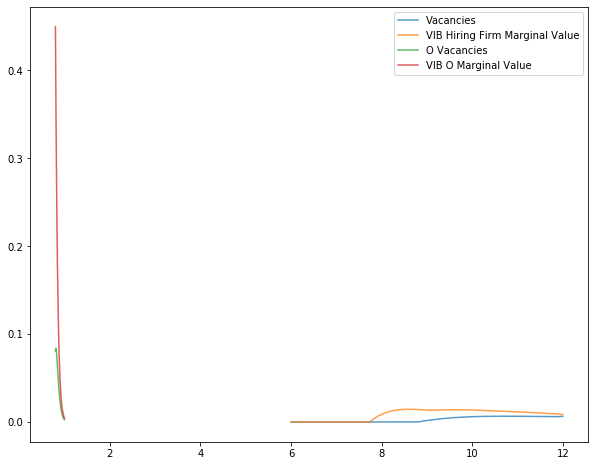

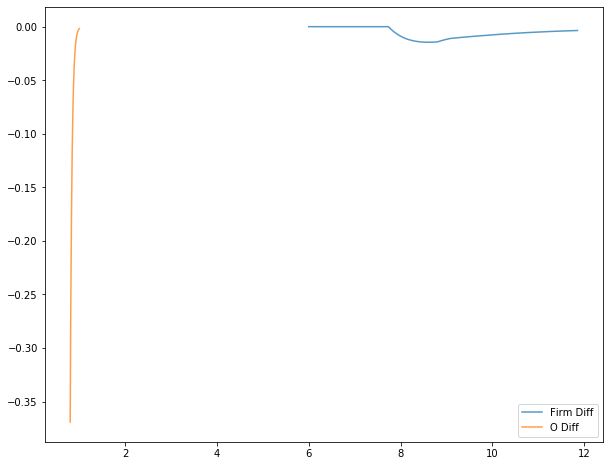

In [55]:
iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

( G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)

# (G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

q = ooj.q
y_grid, o_grid = ooj.y_grid, ooj.o_grid

J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
mc = c(v_grid)    

O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
mc_o = c_o(v_o_grid) 

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
ax.set(xlabel="Productivity $y$", ylabel="Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies")
ax.plot(y_grid, c_inv(J_hire), alpha=0.75, label="VIB Hiring Firm Marginal Value")
ax.plot(o_grid, v_o_grid, alpha=0.75, label="O Vacancies")
ax.plot(o_grid, c_o_inv(O), alpha=0.75, label="VIB O Marginal Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid[:y_hat], v_grid[:y_hat] - c_inv(J_hire)[:y_hat], alpha=0.75, label="Firm Diff")
ax.plot(o_grid, v_o_grid - c_o_inv(O), alpha=0.75, label="O Diff")
ax.legend(loc="best")

plt.show()